# Versión 4

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pyarrow as pa
import pyarrow.parquet as pq

<ipython-input-1-d34d3743e5a7>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga de los espectrogramas - Aplanando

In [ ]:
directorio_principal = r'/content/drive/MyDrive/BigData/'

espectrogramas = []
directorios = []  # Lista para almacenar los nombres de los directorios

for carpeta in os.listdir(directorio_principal):
    carpeta_path = os.path.join(directorio_principal, carpeta)

    # Si la ruta es un directorio
    if os.path.isdir(carpeta_path):
        # Iterar sobre los archivos en la carpeta actual
        for archivo in os.listdir(carpeta_path):
            archivo_path = os.path.join(carpeta_path, archivo)
            # Cargar el espectrograma desde el archivo .npy
            espectrograma = np.load(archivo_path)
            # Aplanar el espectrograma y agregarlo a la lista
            espectrogramas.append(espectrograma.flatten())
            # Agregar el nombre del directorio a la lista
            directorios.append(carpeta)

# Convertir la lista de espectrogramas en un DataFrame
df_espectrogramas = pd.DataFrame(espectrogramas)

# Añadir la columna con el nombre del directorio
df_espectrogramas['Directorio'] = directorios

In [ ]:
df_espectrogramas.tail(2)

In [ ]:
df_espectrogramas['Directorio'].unique()

## Separación de los datos

In [ ]:
# Separamos los datos de los espectogramas según los datos X e y. El target es adivinar el nombre de la especie, o sea el directorio.
X = df_espectrogramas.drop(columns=["Directorio"])
y = df_espectrogramas["Directorio"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Entrenamiento

In [ ]:
from sklearn.neural_network import MLPClassifier
MLPC = MLPClassifier(hidden_layer_sizes=(5,5,5), activation='relu', learning_rate_init=0.01, max_iter=1000, batch_size = 200, solver='adam',
                     random_state=1)

In [ ]:
from sklearn.model_selection import cross_val_score
print("Accuracy en cross-validation:", round(cross_val_score(MLPC, X_train, y_train, cv=5).mean(),2))

In [ ]:
# Realizamos la clasificación para distintos parámetros para encontrar los óptimos
MLPC = MLPClassifier(early_stopping = True,max_iter=1000,activation='relu', batch_size = 200, solver='adam',random_state=1)
parameters = {
    'hidden_layer_sizes': [(5,5,5),(20,20),(100,100,100)],
    'learning_rate_init' : [0.01, 0.00001]
    }
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(MLPC, parameters, cv=5, verbose = True)
grid_search.fit(X_train, y_train)
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("He obtenido una accuracy de %0.3f (+/-%0.03f) con los parámetros %r" % (mean, std * 2, params))

In [ ]:
print("Los mejores parámetros son ", grid_search.best_params_)

In [ ]:
from sklearn.metrics import accuracy_score
# Entrenamiento con todo el dataset de train sacando precisión del test.
new_MPLC = MLPClassifier(**grid_search.best_params_,max_iter=1000,activation='relu',
                                batch_size = 200, solver='adam',random_state=1)
new_MPLC.fit(X_train, y_train)
predicciones = new_MPLC.predict(X_test)
print("Accuracy en test: ", accuracy_score(predicciones, y_test) )

In [ ]:
print("Iteraciones realizadas por el modelo =", len(new_MPLC.loss_curve_))
plt.plot(new_MPLC.loss_curve_, color='Blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [ ]:
# Parece que la pérdida seguiría decreciendo con más iteraciones.
# Vamos a realizar algunas iteraciones más.
# Se añaden los parámetros: tol = 0, n_iter_no_change=1000
new2_MPLC = MLPClassifier(**grid_search.best_params_, early_stopping = True,
                         max_iter=1000,activation='relu', batch_size = 200,
                         solver='adam',random_state=1, tol = 0, n_iter_no_change=1000)
new2_MPLC.fit(X_train, y_train)
predicciones2 = new2_MPLC.predict(X_test)
print("Accuracy en test: ", accuracy_score(predicciones2, y_test) )

In [ ]:
print("Iteraciones realizadas por el modelo 2 =", len(new2_MPLC.loss_curve_))
plt.plot(new2_MPLC.loss_curve_, color='Red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [ ]:
print("Iteraciones realizadas por el modelo 2 =", len(new2_MPLC.loss_curve_))

# Graficar solo hasta las primeras 100 iteraciones
plt.plot(new2_MPLC.loss_curve_[:100], color='Red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve (First 100 Iterations)')
plt.show()

## Carga de los espectogramas - Sin Aplanar

In [ ]:
## Código inicial (code 27)
directorio_principal = r'/content/drive/MyDrive/BigData/'

espectrogramas = []
directorios = []  # Lista para almacenar los nombres de los directorios

for carpeta in os.listdir(directorio_principal):
    carpeta_path = os.path.join(directorio_principal, carpeta)

    # Si la ruta es un directorio
    if os.path.isdir(carpeta_path):
        # Iterar sobre los archivos en la carpeta actual
        for archivo in os.listdir(carpeta_path):
            archivo_path = os.path.join(carpeta_path, archivo)
            # Cargar el espectrograma desde el archivo .npy sin aplanar
            espectrograma = np.load(archivo_path)
            espectrogramas.append(espectrograma)  # Agregar el espectrograma sin aplanar
            directorios.append(carpeta)  # Agregar el nombre del directorio

# Convertir la lista de espectrogramas en un DataFrame
df_espectrogramas = pd.DataFrame({'Espectrograma': espectrogramas, 'Directorio': directorios})

In [ ]:
df_espectrogramas.tail(2)

,Espectrograma,Directorio
17404,"[[-9.835439, -10.877673, -11.775661, -17.87937...",Ixobrychus minutus
17405,"[[-1.3705153, -4.135847, -7.592842, -6.14003, ...",Ixobrychus minutus


In [ ]:
## Código final (code 28)
# Directorio principal donde están los archivos .npy
directorio_principal = r'/content/drive/MyDrive/BigData/'
main_folder = "/content/drive/MyDrive/BigData/"

# Parámetros para el procesamiento por lotes
batch_size = 250  # Número de espectrogramas a procesar por lote
temp_files = []   # Lista para almacenar los nombres de archivos temporales

# Función para procesar y guardar un lote de datos
def process_and_save_batch(espectrogramas, directorios, batch_index):
    espectrograma_df = pd.DataFrame(espectrogramas)
    espectrograma_df.columns = [f'Espectrograma_{i}' for i in range(espectrograma_df.shape[1])]
    df_batch = pd.concat([espectrograma_df, pd.DataFrame({'Directorio': directorios})], axis=1)

    # Guardar el lote en un archivo Parquet temporal
    temp_file = os.path.join(main_folder, f"temp_batch_{batch_index}.parquet")
    df_batch.to_parquet(temp_file, index=False)
    temp_files.append(temp_file)

# Inicializar variables
espectrogramas = []
directorios = []
batch_index = 0

# Recorrer las carpetas en el directorio principal
for carpeta in os.listdir(directorio_principal):
    carpeta_path = os.path.join(directorio_principal, carpeta)

    # Si la ruta es un directorio
    if os.path.isdir(carpeta_path):
        # Iterar sobre los archivos en la carpeta actual
        for archivo in os.listdir(carpeta_path):
            archivo_path = os.path.join(carpeta_path, archivo)
            # Cargar el espectrograma desde el archivo .npy
            espectrograma = np.load(archivo_path)
            # Aplanar el espectrograma y agregarlo a la lista
            espectrogramas.append(espectrograma.flatten())
            # Agregar el nombre del directorio a la lista
            directorios.append(carpeta)

            # Si alcanzamos el tamaño del lote, procesar y guardar
            if len(espectrogramas) == batch_size:
                process_and_save_batch(espectrogramas, directorios, batch_index)
                espectrogramas = []
                directorios = []
                batch_index += 1

# Procesar y guardar cualquier dato restante
if espectrogramas:
    process_and_save_batch(espectrogramas, directorios, batch_index)

# Combinar todos los archivos Parquet temporales en uno solo
final_table = pa.concat_tables([pq.read_table(temp_file) for temp_file in temp_files])
pq.write_table(final_table, os.path.join(main_folder, "df_espectrogramas_final.parquet"))

# Eliminar archivos temporales
for temp_file in temp_files:
    os.remove(temp_file)

print("Proceso completado y archivo Parquet final guardado.")

Proceso completado y archivo Parquet final guardado.


## Observar y graficar los datos

In [2]:
# Read df_espectrogramas
main_folder = "/content/drive/MyDrive/BigData/"
df_espectrogramas = pd.read_parquet(os.path.join(main_folder, "df_espectrogramas_final.parquet"))
df_espectrogramas.tail(2)

,Espectrograma_0,Espectrograma_1,Espectrograma_2,Espectrograma_3,Espectrograma_4,Espectrograma_5,Espectrograma_6,Espectrograma_7,Espectrograma_8,Espectrograma_9,...,Espectrograma_50167,Espectrograma_50168,Espectrograma_50169,Espectrograma_50170,Espectrograma_50171,Espectrograma_50172,Espectrograma_50173,Espectrograma_50174,Espectrograma_50175,Directorio
17404,-9.835439,-10.877673,-11.775661,-17.879377,-12.524467,-9.85652,-10.989324,-13.376041,-7.402369,-11.099800,...,-59.244942,-61.010590,-64.294510,-56.733818,-58.022129,-77.640419,-75.398094,-70.155693,-69.562279,Ixobrychus minutus
17405,-1.370515,-4.135847,-7.592842,-6.140030,-24.290020,-15.65752,-6.993004,-13.294864,-8.121881,-7.036368,...,-66.358452,-68.334244,-63.617203,-61.018921,-63.104874,-68.724838,-68.640526,-67.770973,-68.837791,Ixobrychus minutus


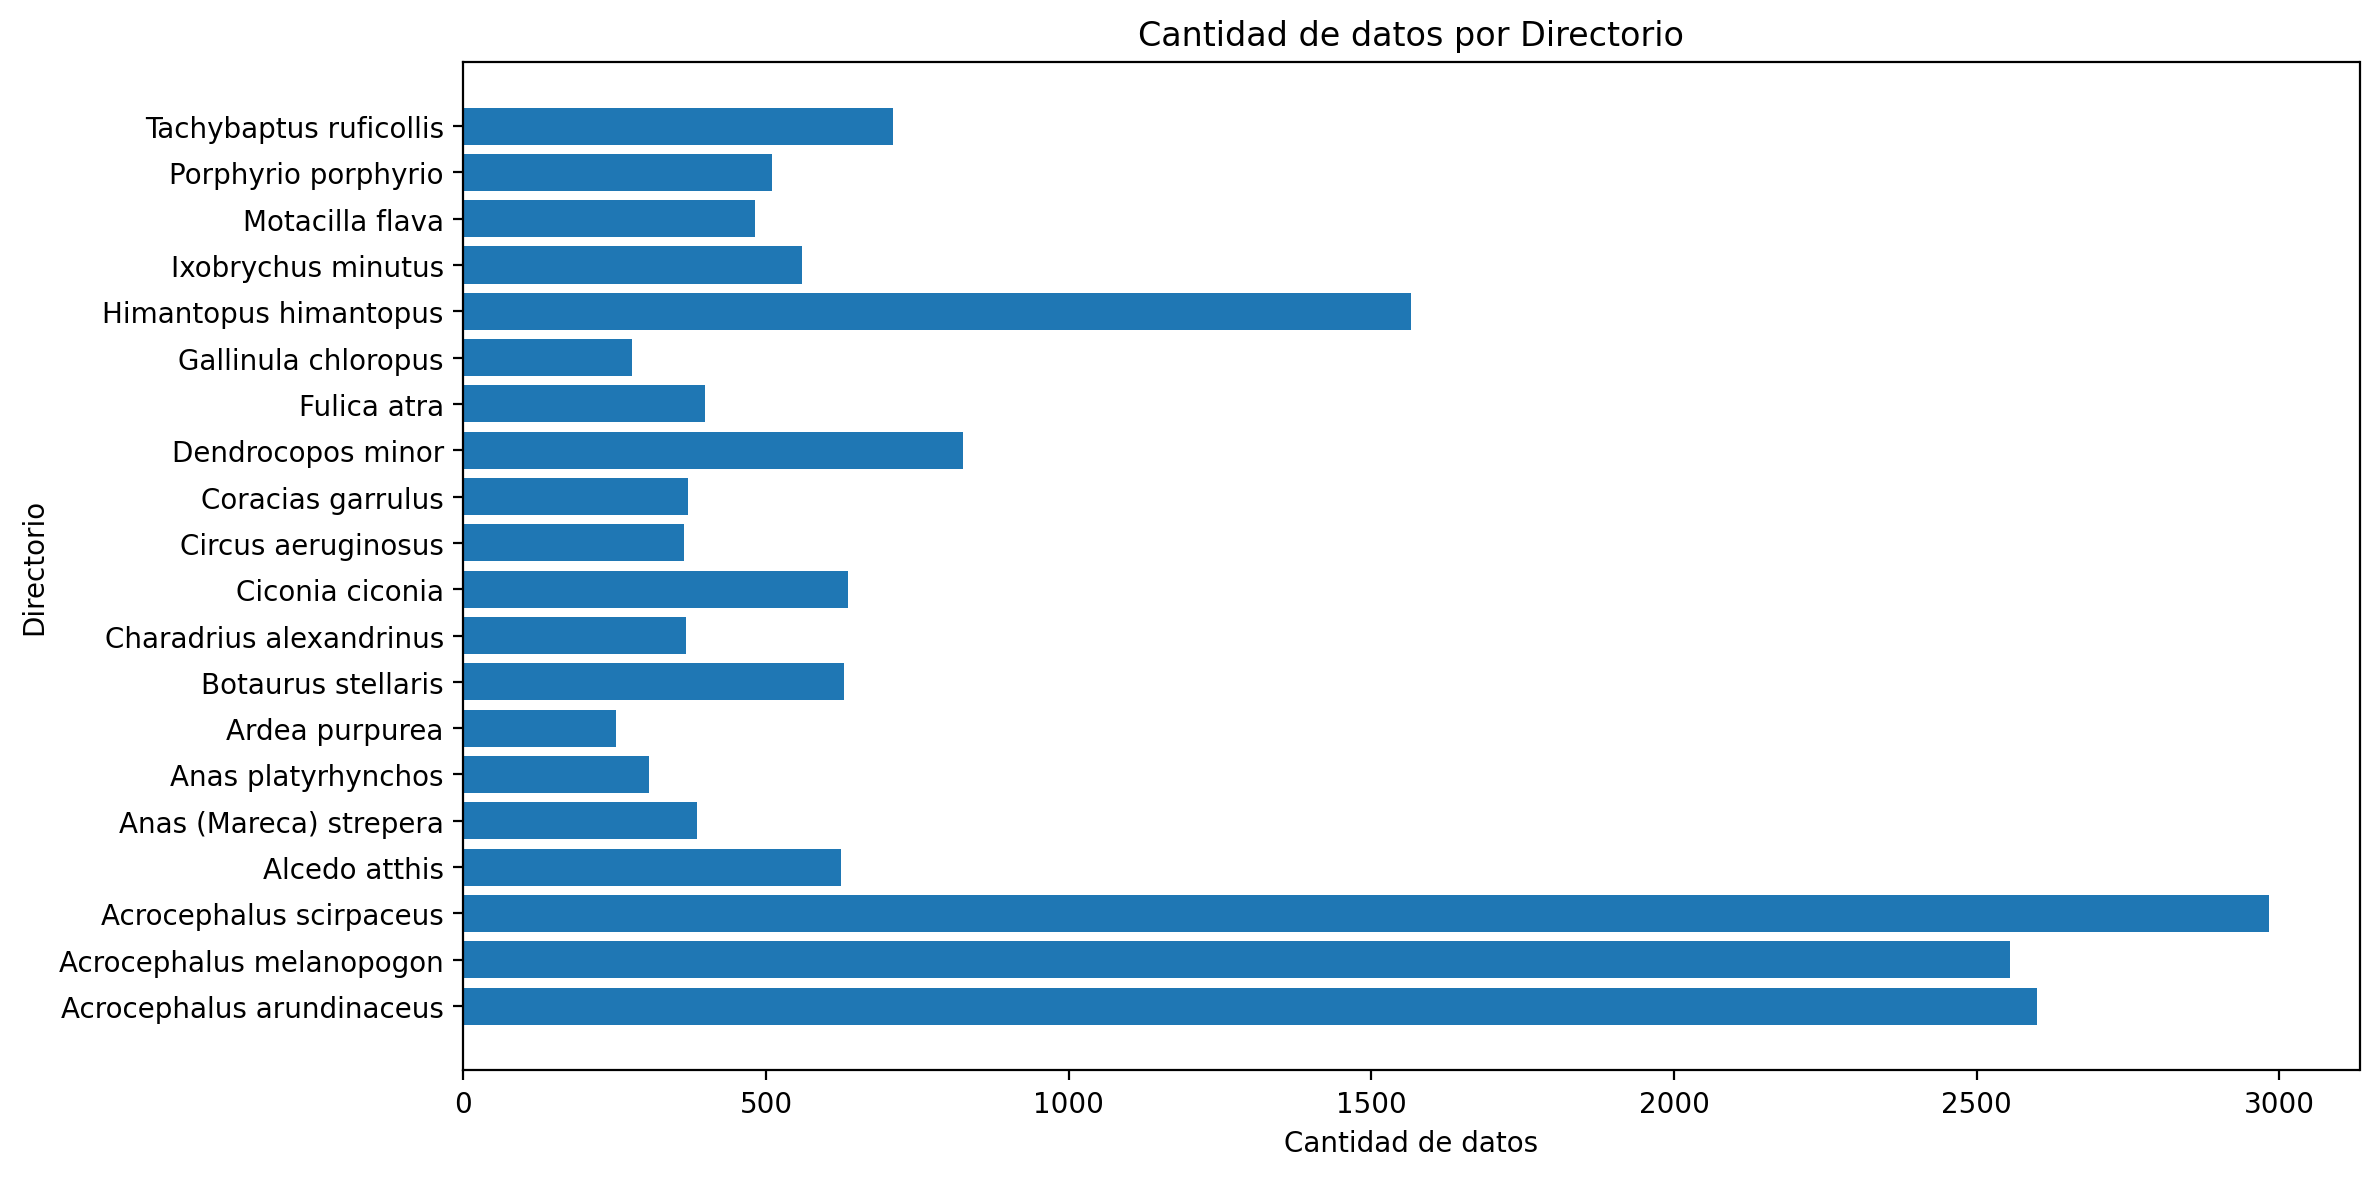

In [ ]:
# Contar la cantidad de datos de cada "Directorio"
count_per_species = df_espectrogramas["Directorio"].value_counts().sort_index()

# Crear el diagrama de barras de cantidad de datos por "Directorio"
plt.figure(figsize=(12, 6))
plt.barh(count_per_species.index, count_per_species.values)
plt.ylabel("Directorio")
plt.xlabel("Cantidad de datos")
plt.title("Cantidad de datos por Directorio")
plt.tight_layout()
plt.show()

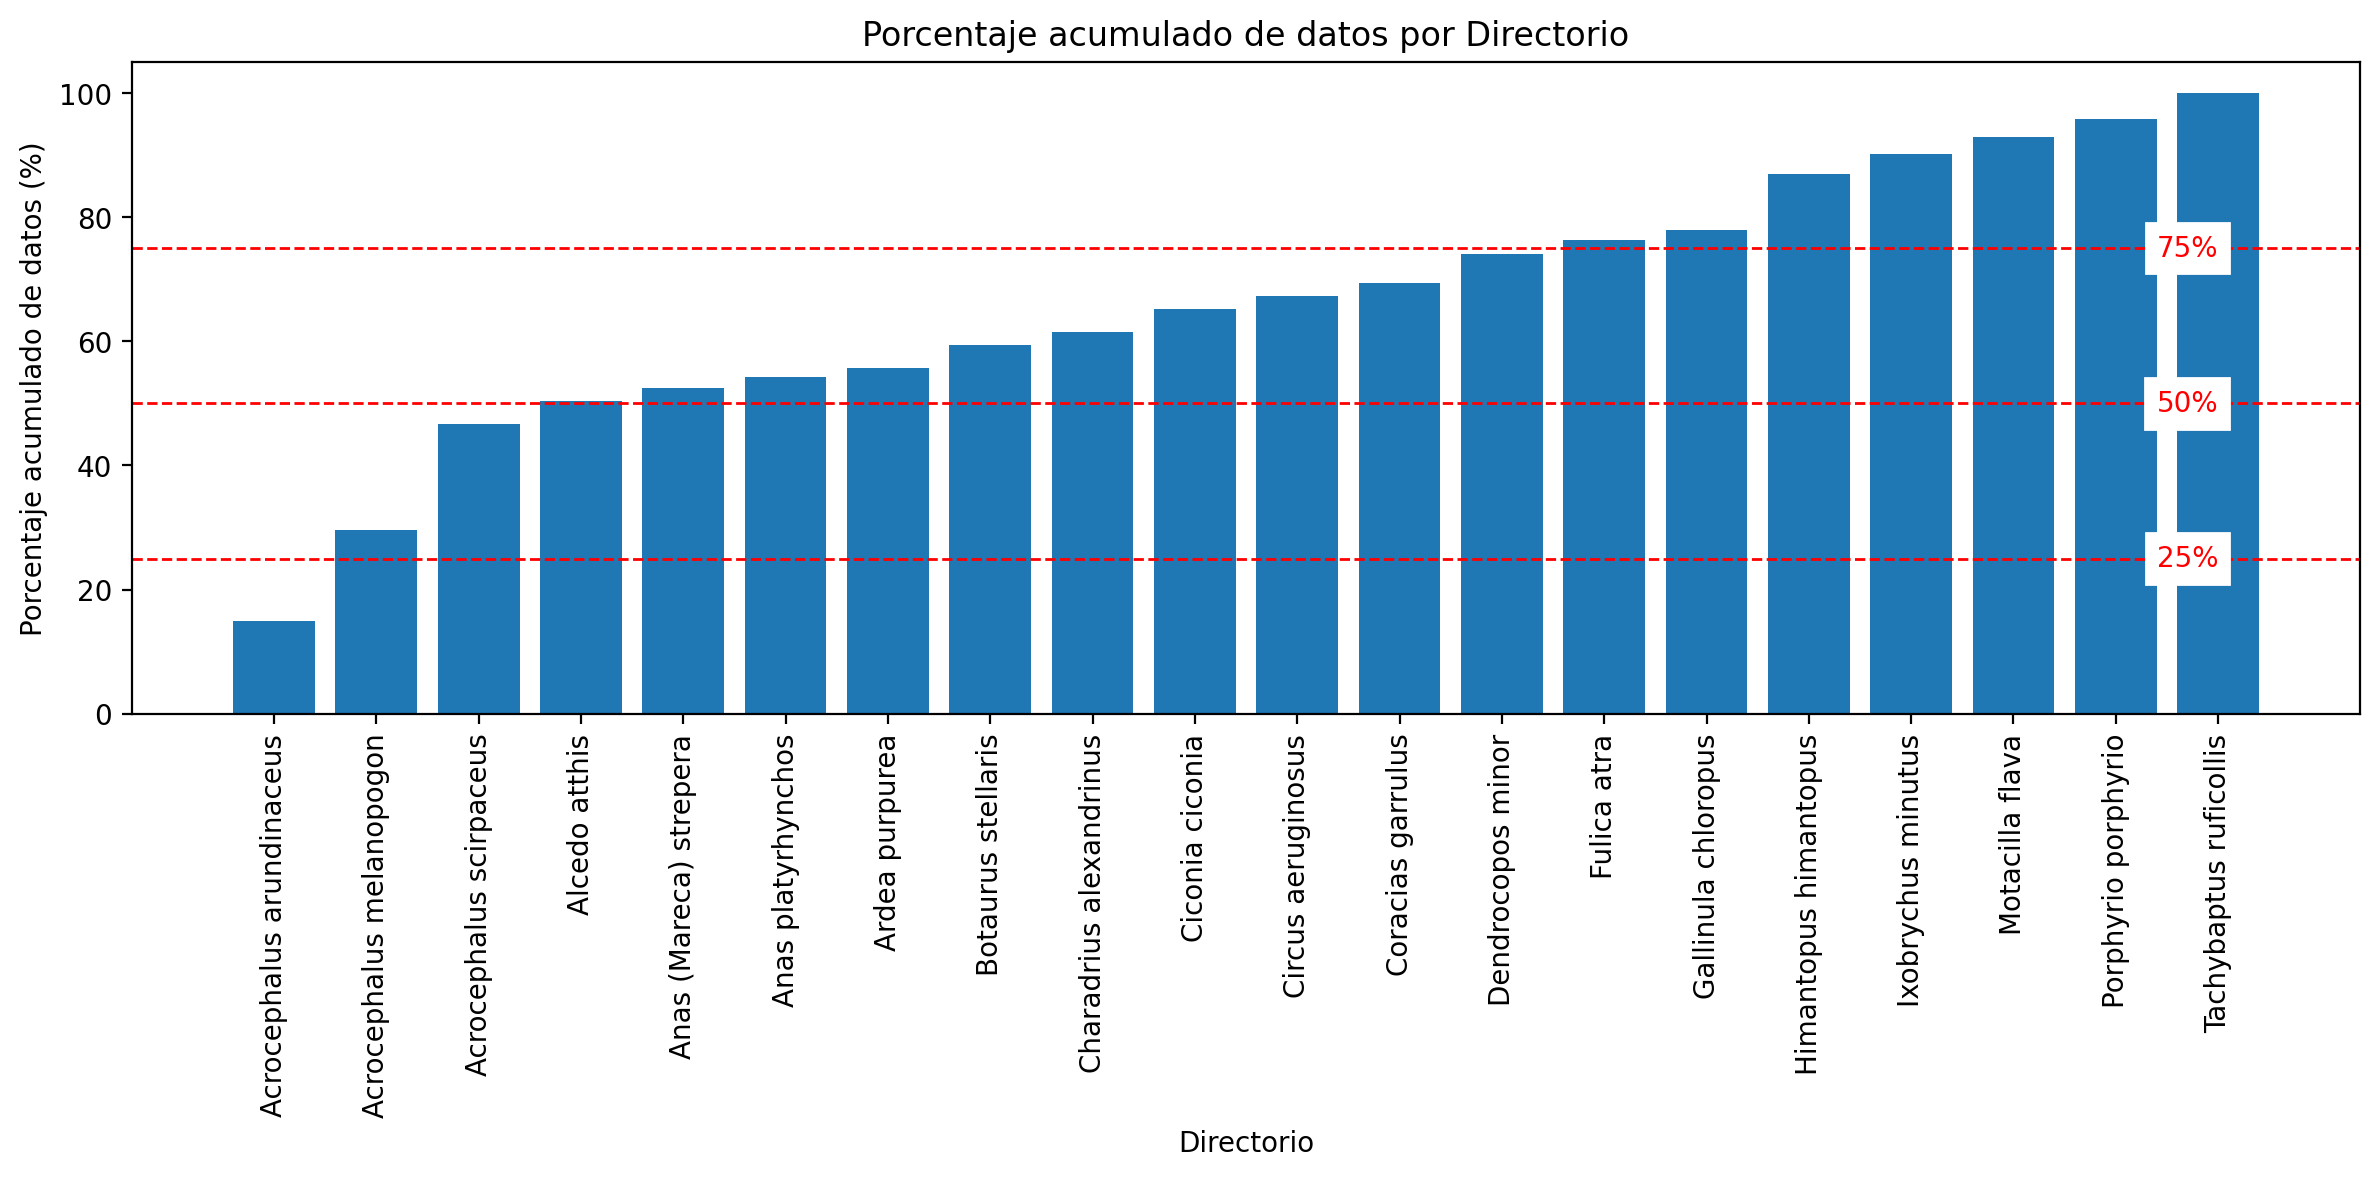

In [ ]:
# Calcular la cantidad acumulada de datos por "Directorio"
cumulative_count = count_per_species.cumsum()

# Calcular el porcentaje acumulado de datos
total_count = cumulative_count.iloc[-1]
percentage_cumulative = cumulative_count / total_count * 100

# Crear el diagrama de barras de porcentaje acumulado de datos por "Directorio"
plt.figure(figsize=(12, 6))
plt.bar(percentage_cumulative.index, percentage_cumulative.values)
plt.xlabel("Directorio")
plt.ylabel("Porcentaje acumulado de datos (%)")
plt.title("Porcentaje acumulado de datos por Directorio")
plt.xticks(rotation=90)

# Añadir líneas de referencia para 25%, 50% y 75%
plt.axhline(25, color='red', linestyle='--', linewidth=1)
plt.axhline(50, color='red', linestyle='--', linewidth=1)
plt.axhline(75, color='red', linestyle='--', linewidth=1)

# Añadir etiquetas a las líneas de referencia
plt.text(19, 25, '25%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(19, 50, '50%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(19, 75, '75%', color='red', va='center', ha='right', backgroundcolor='white')

plt.tight_layout()
plt.show()

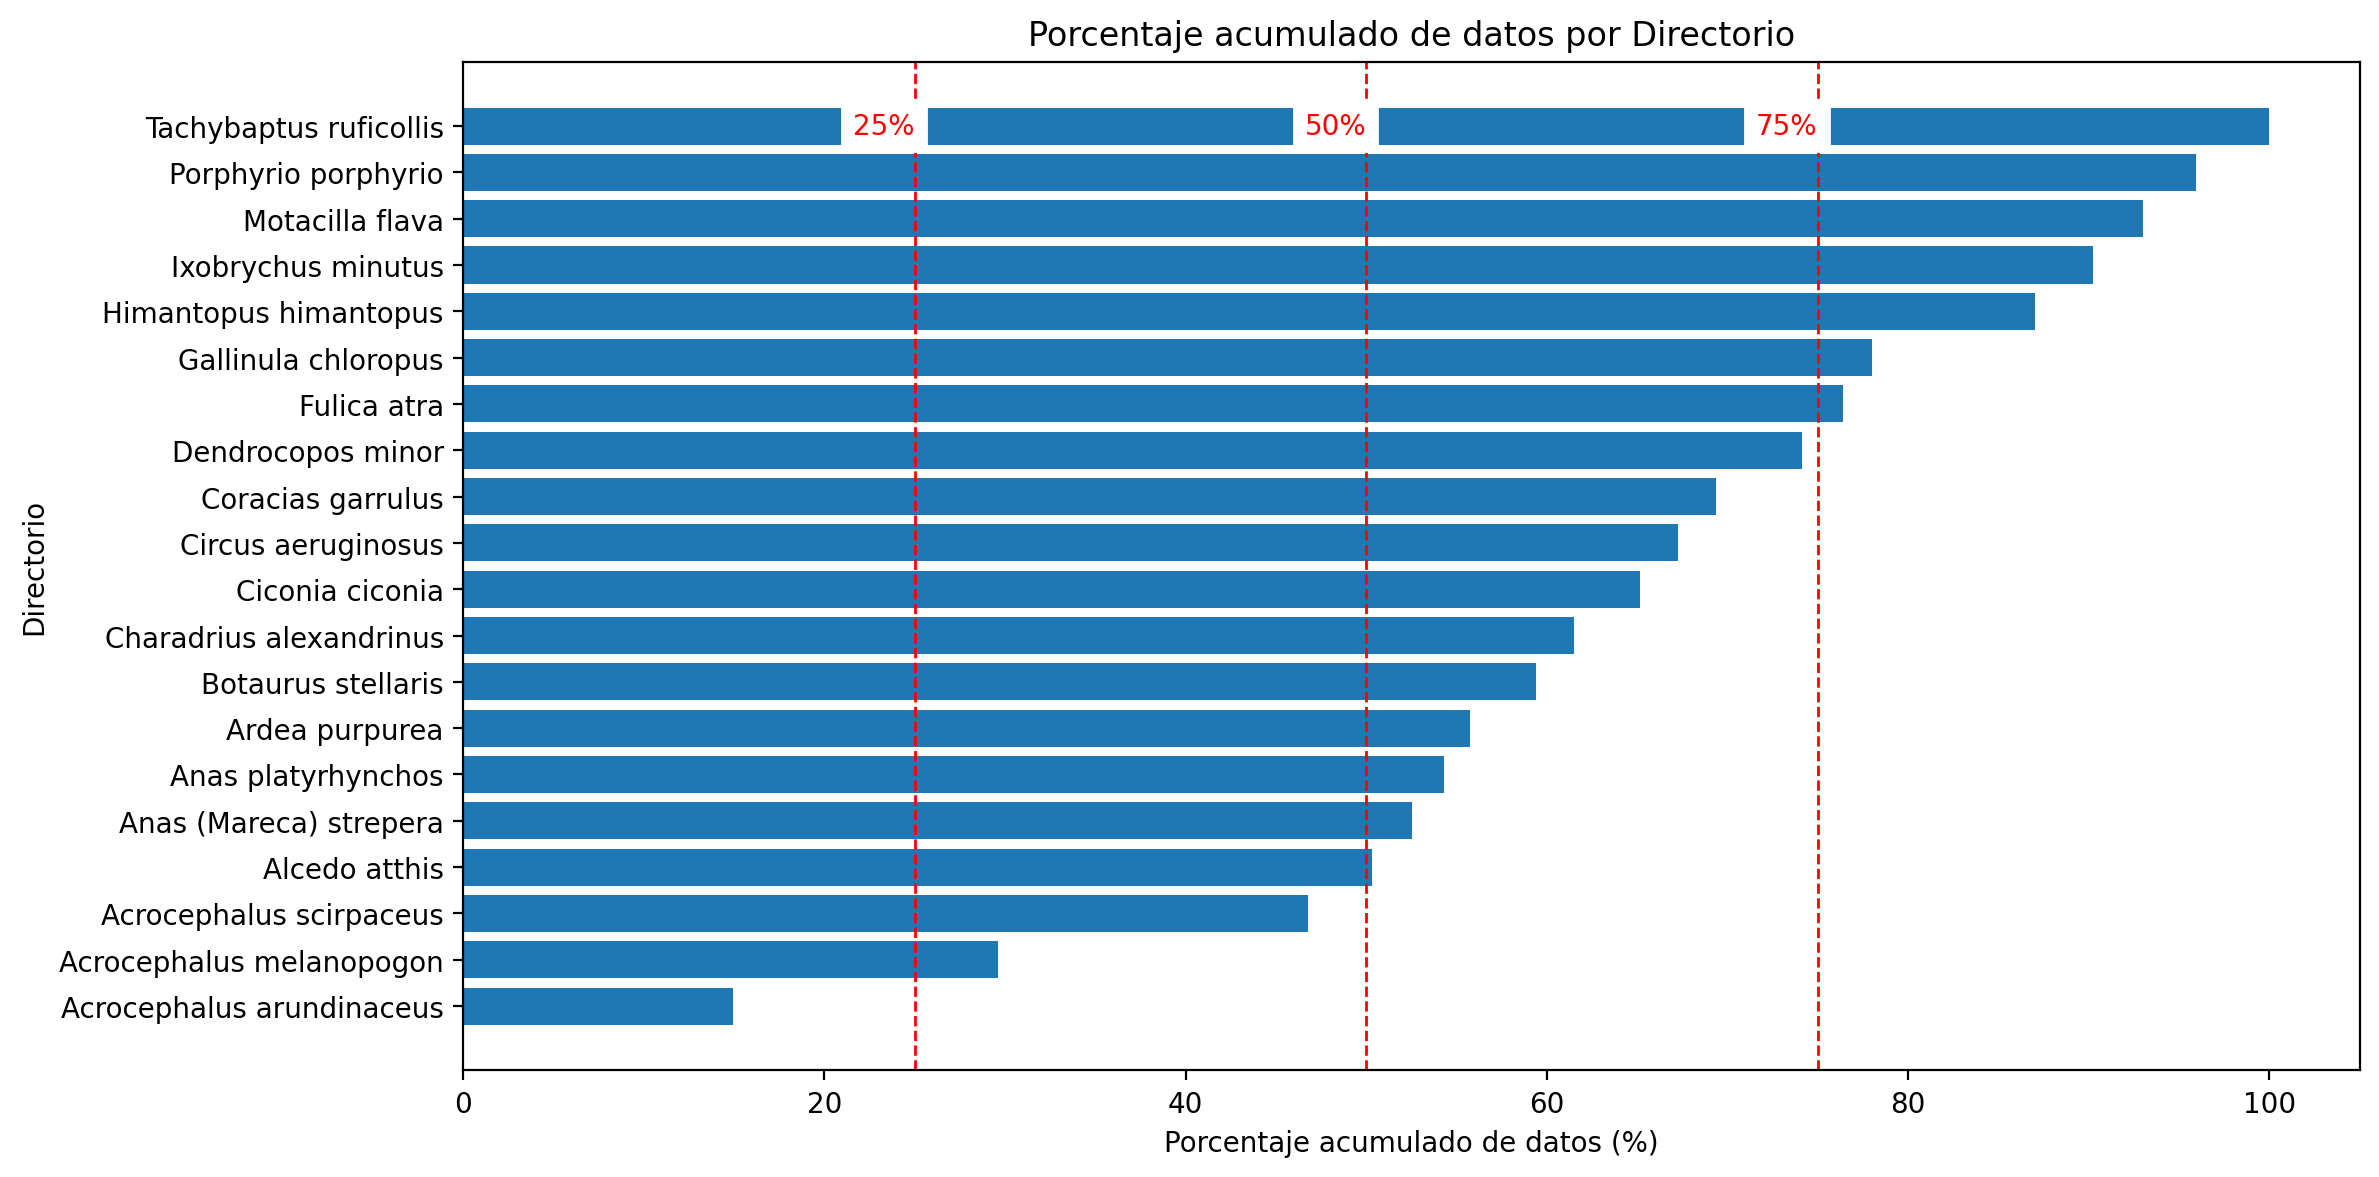

In [ ]:
# Calcular la cantidad acumulada de datos por "Directorio"
cumulative_count = count_per_species.cumsum()

# Calcular el porcentaje acumulado de datos
total_count = cumulative_count.iloc[-1]
percentage_cumulative = cumulative_count / total_count * 100

# Crear el diagrama de barras horizontal de porcentaje acumulado de datos por "Directorio"
plt.figure(figsize=(12, 6))
plt.barh(percentage_cumulative.index, percentage_cumulative.values)
plt.ylabel("Directorio")
plt.xlabel("Porcentaje acumulado de datos (%)")
plt.title("Porcentaje acumulado de datos por Directorio")

# Añadir líneas de referencia para 25%, 50% y 75%
plt.axvline(25, color='red', linestyle='--', linewidth=1)
plt.axvline(50, color='red', linestyle='--', linewidth=1)
plt.axvline(75, color='red', linestyle='--', linewidth=1)

# Añadir etiquetas a las líneas de referencia
plt.text(25, 19, '25%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(50, 19, '50%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(75, 19, '75%', color='red', va='center', ha='right', backgroundcolor='white')

plt.tight_layout()
plt.show()

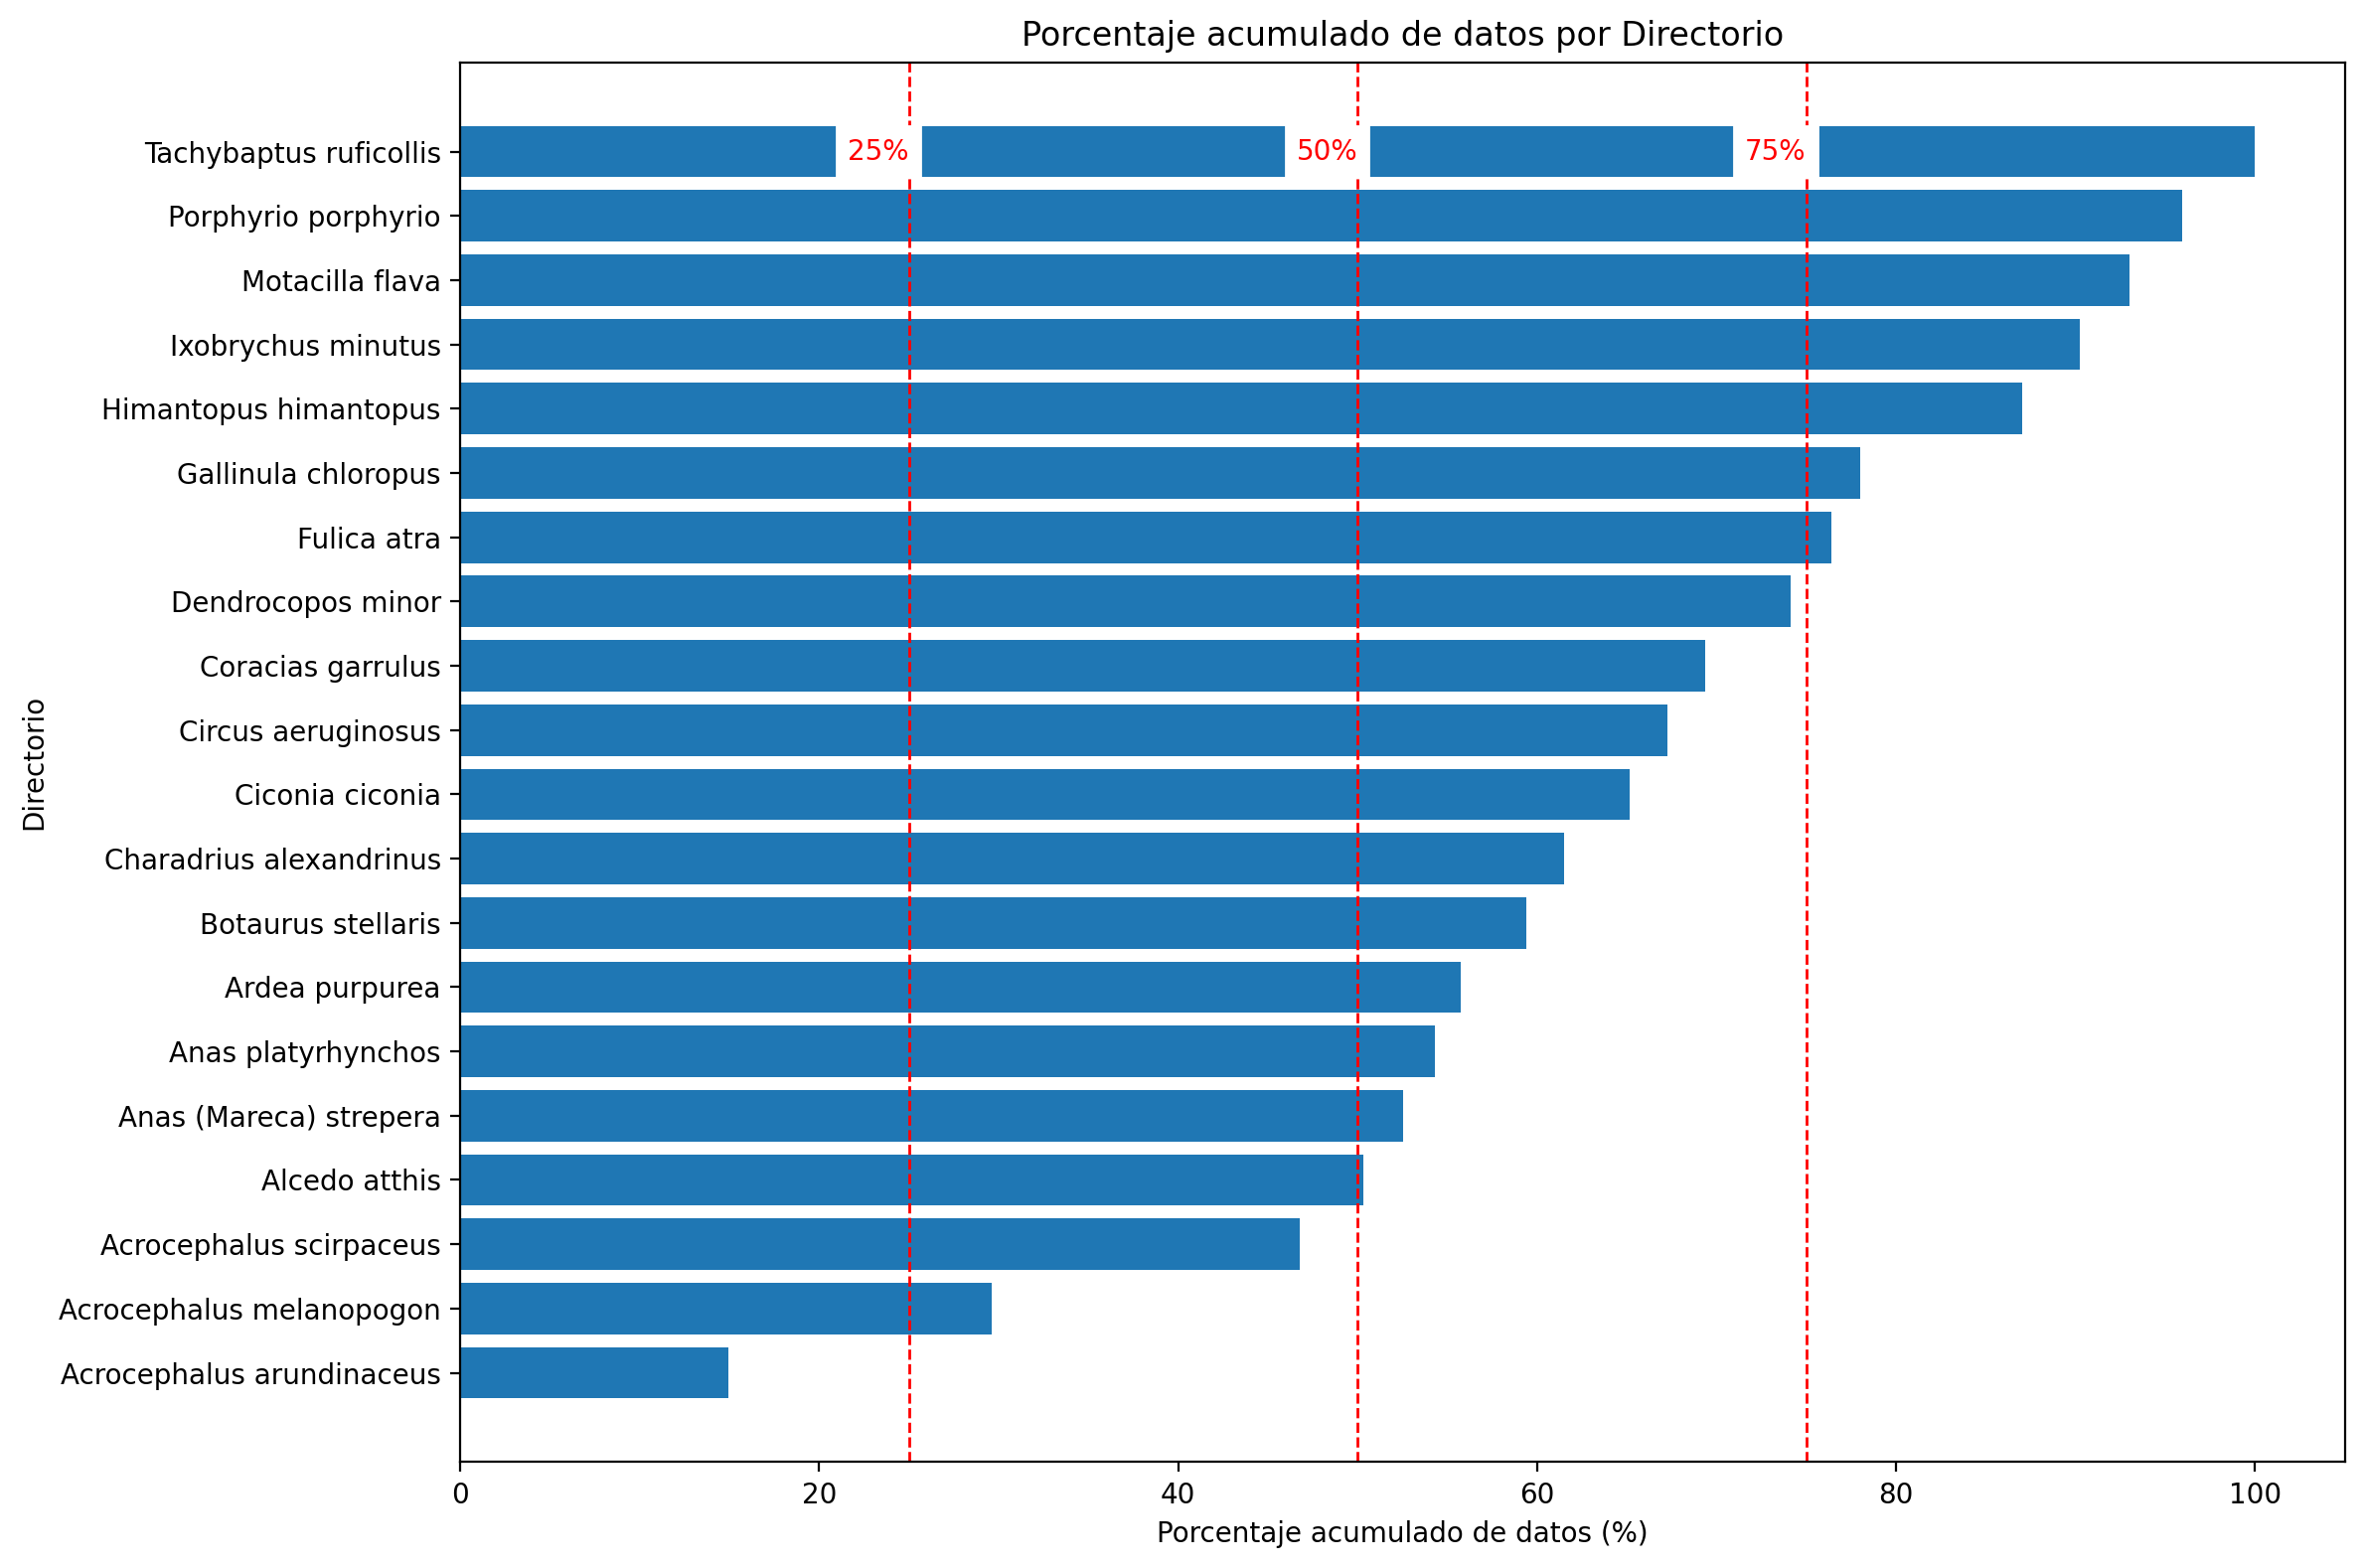

In [ ]:
# Contar la cantidad de datos de cada "Directorio"
count_per_species = df_espectrogramas["Directorio"].value_counts().sort_index()

# Calcular la cantidad acumulada de datos por "Directorio"
cumulative_count = count_per_species.cumsum()

# Calcular el porcentaje acumulado de datos
total_count = cumulative_count.iloc[-1]
percentage_cumulative = cumulative_count / total_count * 100

# Ordenar los directorios por porcentaje acumulado
sorted_directorios = percentage_cumulative.sort_values()

# Dividir en dos mitades para que la mitad de los directorios estén por debajo del 50% y la otra mitad por encima
mid_index = len(sorted_directorios) // 2
sorted_directorios_below_50 = sorted_directorios.iloc[:mid_index]
sorted_directorios_above_50 = sorted_directorios.iloc[mid_index:]

# Combinar para tener los directorios ordenados como se desea
sorted_directorios_combined = pd.concat([sorted_directorios_below_50, sorted_directorios_above_50])

# Crear el diagrama de barras horizontal de porcentaje acumulado de datos por "Directorio"
plt.figure(figsize=(12, 8))
plt.barh(sorted_directorios_combined.index, sorted_directorios_combined.values)
plt.ylabel("Directorio")
plt.xlabel("Porcentaje acumulado de datos (%)")
plt.title("Porcentaje acumulado de datos por Directorio")

# Añadir líneas de referencia para 25%, 50% y 75%
plt.axvline(25, color='red', linestyle='--', linewidth=1)
plt.axvline(50, color='red', linestyle='--', linewidth=1)
plt.axvline(75, color='red', linestyle='--', linewidth=1)

# Añadir etiquetas a las líneas de referencia
plt.text(25, len(sorted_directorios_combined) - 1, '25%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(50, len(sorted_directorios_combined) - 1, '50%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(75, len(sorted_directorios_combined) - 1, '75%', color='red', va='center', ha='right', backgroundcolor='white')

plt.tight_layout()
plt.show()

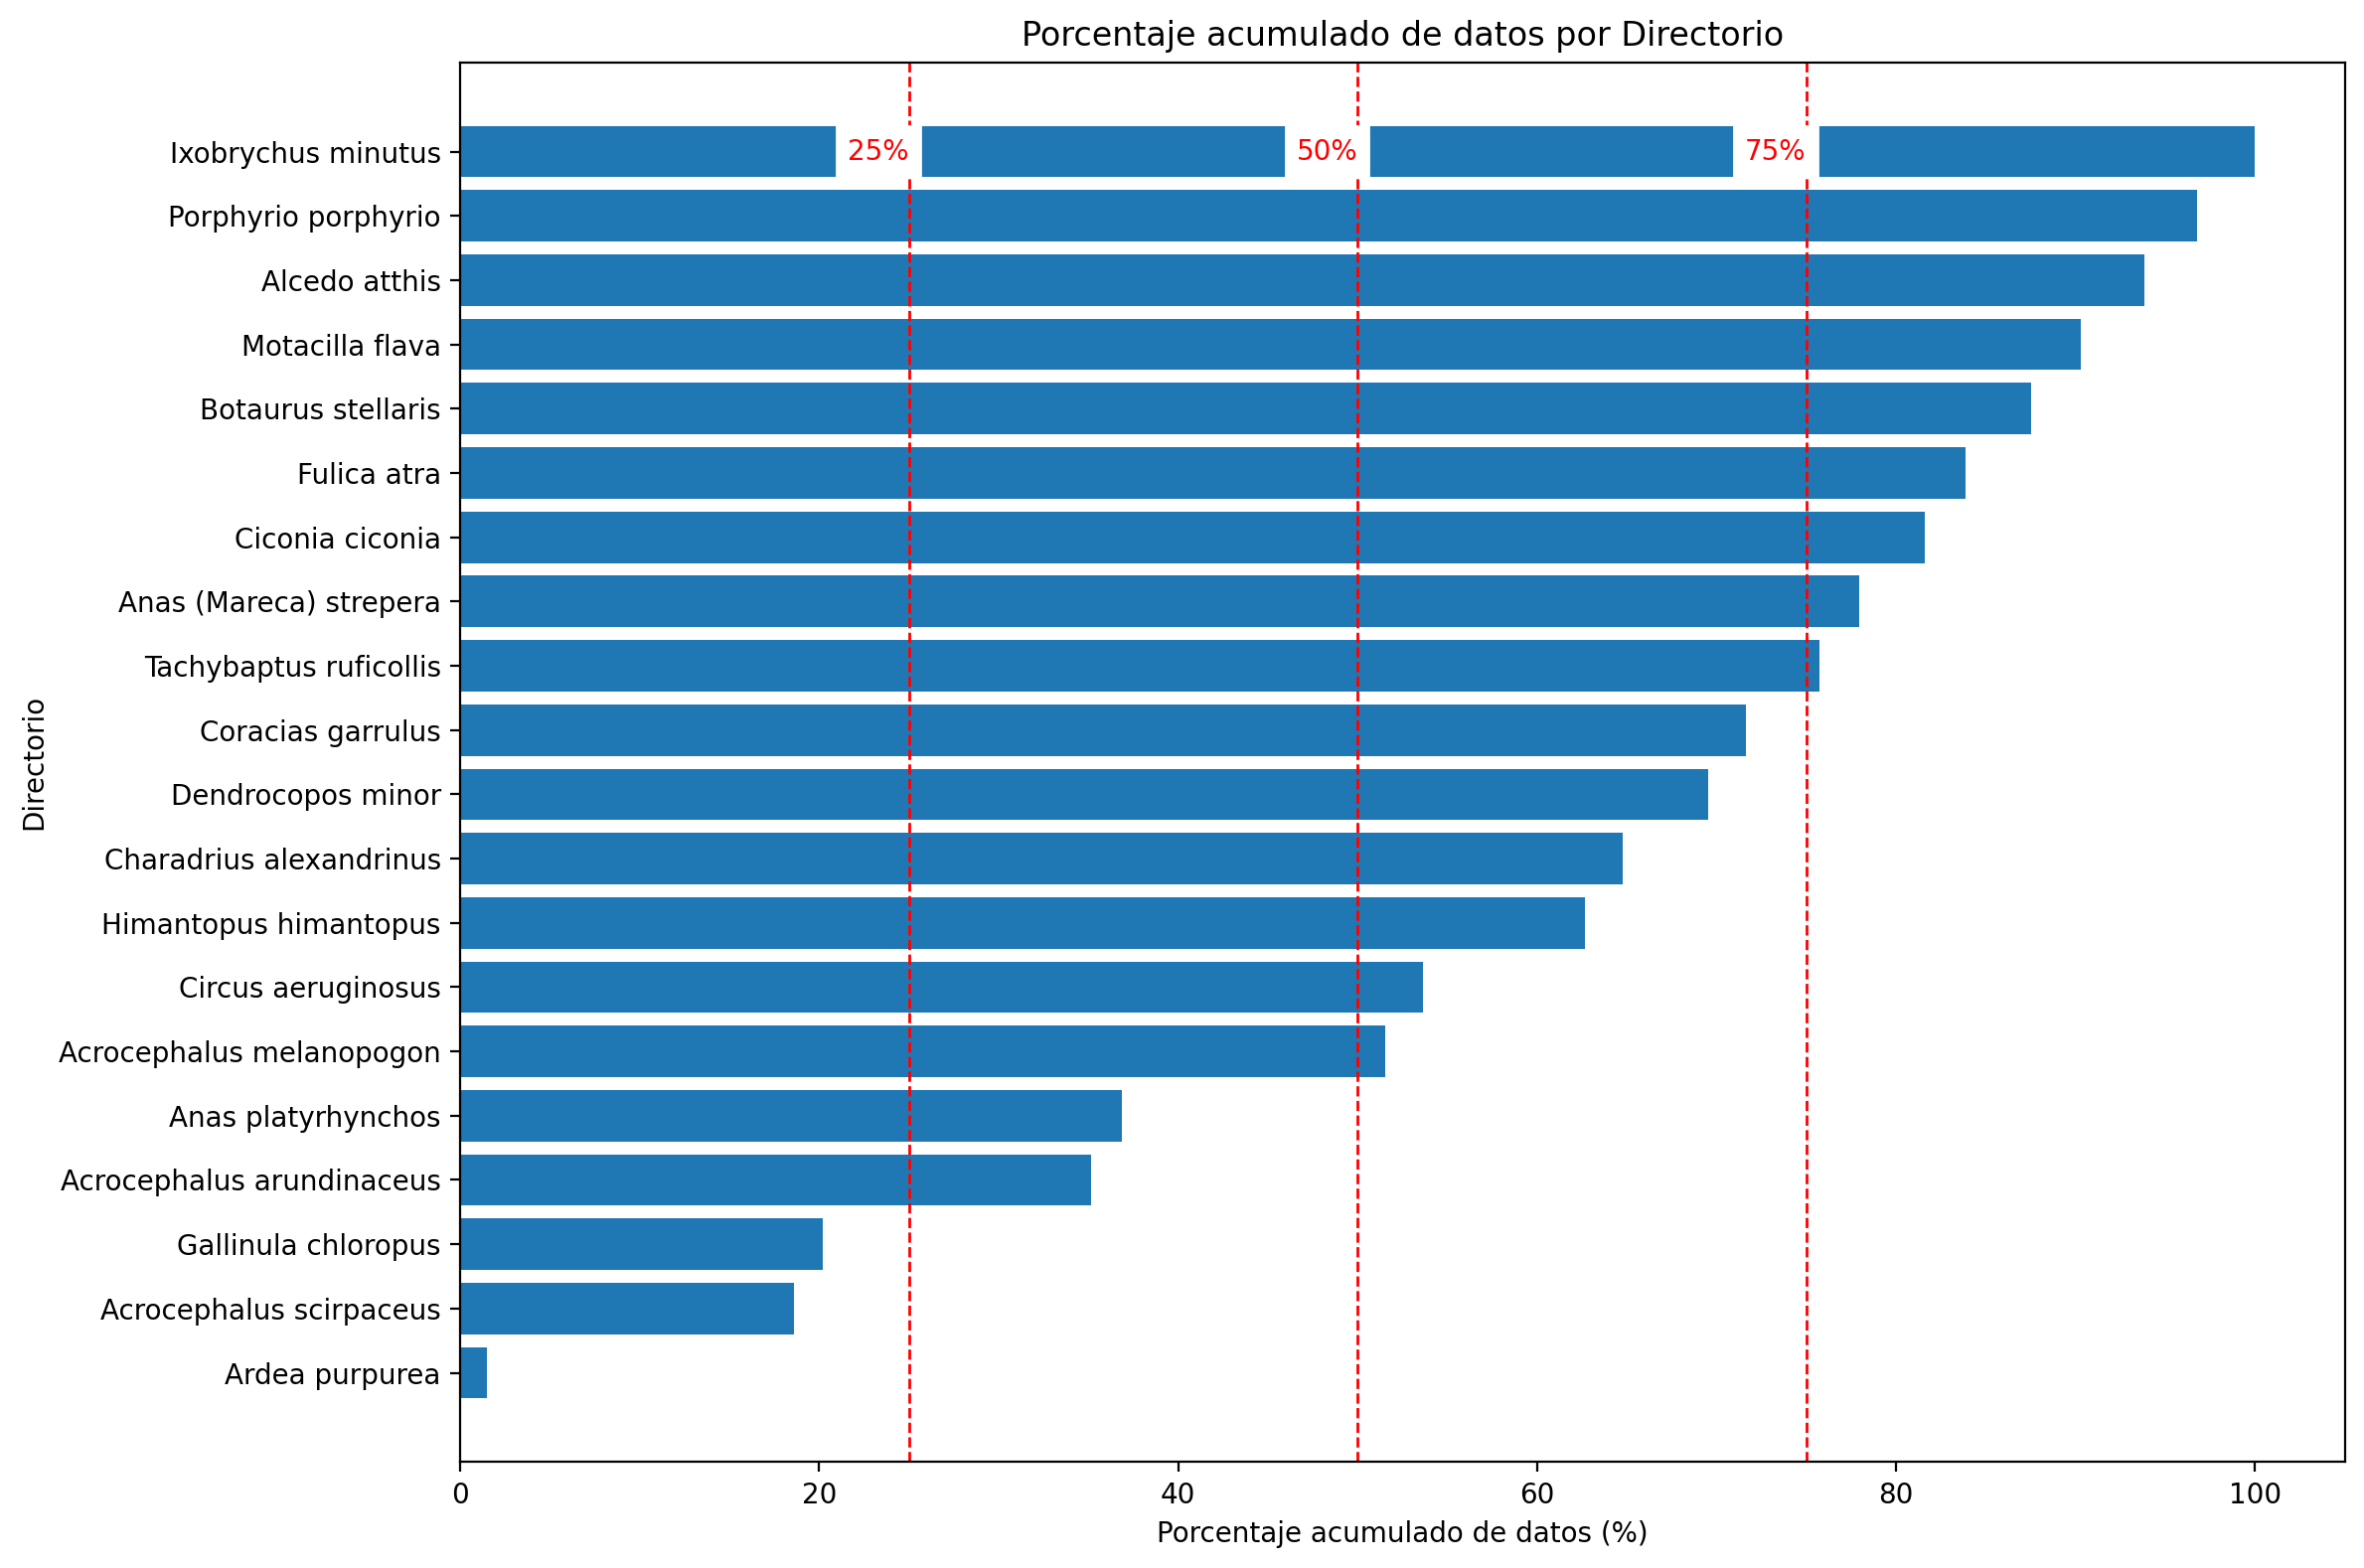

In [ ]:
# Contar la cantidad de datos de cada "Directorio"
count_per_species = df_espectrogramas["Directorio"].value_counts().sort_index()

# Ordenar los directorios de menor a mayor cantidad
sorted_directorios = count_per_species.sort_values()

# Crear listas para alternar entre los más pequeños y los más grandes
alternating_directorios = []
i, j = 0, len(sorted_directorios) - 1

# Alternar entre el menor y el mayor
while i <= j:
    if i == j:
        alternating_directorios.append(sorted_directorios.index[i])
    else:
        alternating_directorios.append(sorted_directorios.index[i])
        alternating_directorios.append(sorted_directorios.index[j])
    i += 1
    j -= 1

# Reorganizar los datos de acuerdo con el nuevo orden
sorted_counts_alternating = sorted_directorios[alternating_directorios]

# Calcular la cantidad acumulada de datos por "Directorio"
cumulative_count = sorted_counts_alternating.cumsum()

# Calcular el porcentaje acumulado de datos
total_count = cumulative_count.iloc[-1]
percentage_cumulative = cumulative_count / total_count * 100

# Crear el diagrama de barras horizontal de porcentaje acumulado de datos por "Directorio"
plt.figure(figsize=(12, 8))
plt.barh(percentage_cumulative.index, percentage_cumulative.values)
plt.ylabel("Directorio")
plt.xlabel("Porcentaje acumulado de datos (%)")
plt.title("Porcentaje acumulado de datos por Directorio")

# Añadir líneas de referencia para 25%, 50% y 75%
plt.axvline(25, color='red', linestyle='--', linewidth=1)
plt.axvline(50, color='red', linestyle='--', linewidth=1)
plt.axvline(75, color='red', linestyle='--', linewidth=1)

# Añadir etiquetas a las líneas de referencia
plt.text(25, len(percentage_cumulative) - 1, '25%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(50, len(percentage_cumulative) - 1, '50%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(75, len(percentage_cumulative) - 1, '75%', color='red', va='center', ha='right', backgroundcolor='white')

plt.tight_layout()
plt.show()

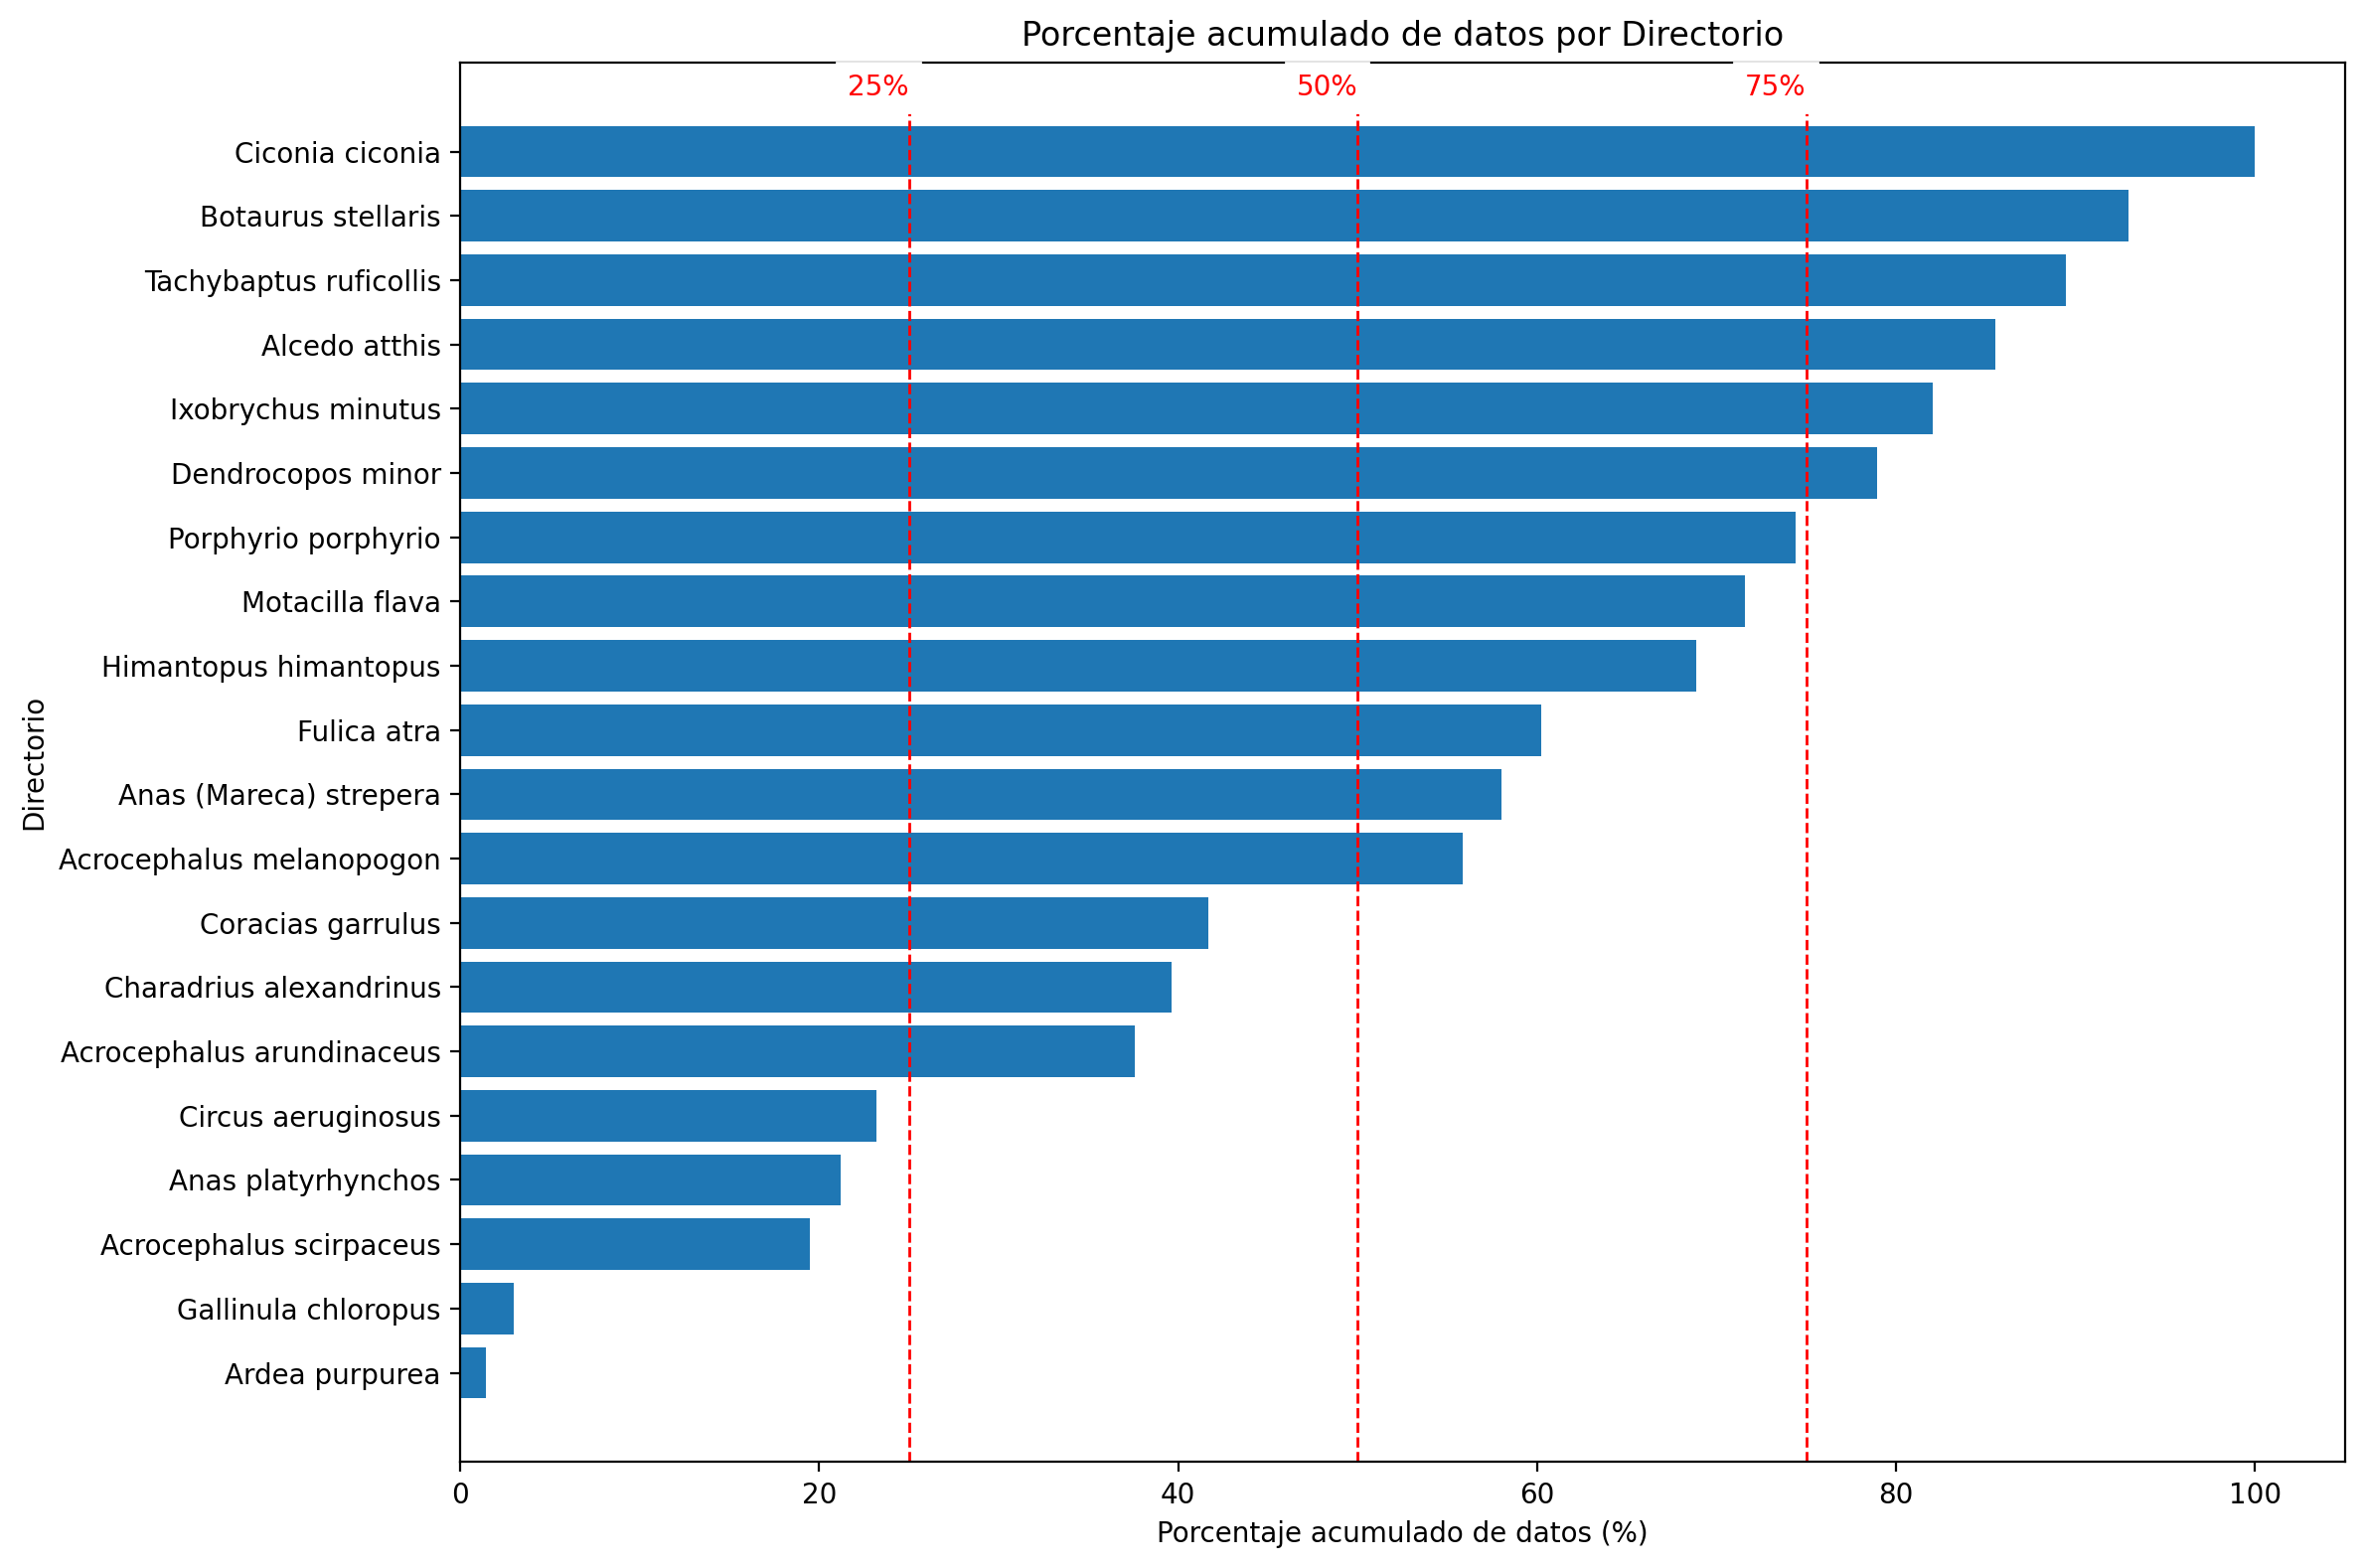

In [ ]:
# Contar la cantidad de datos de cada "Directorio"
count_per_species = df_espectrogramas["Directorio"].value_counts().sort_index()

# Ordenar los directorios de menor a mayor cantidad
sorted_directorios = count_per_species.sort_values()

# Crear listas para alternar entre dos de los más pequeños y uno de los más grandes
alternating_directorios = []
i, j = 0, len(sorted_directorios) - 1

# Alternar dos de menor cantidad primero por cada uno de mayor cantidad
while i <= j:
    if i < len(sorted_directorios):
        alternating_directorios.append(sorted_directorios.index[i])
        i += 1
    if i < len(sorted_directorios):
        alternating_directorios.append(sorted_directorios.index[i])
        i += 1
    if j >= 0:
        alternating_directorios.append(sorted_directorios.index[j])
        j -= 1

# Reorganizar los datos de acuerdo con el nuevo orden
sorted_counts_alternating = sorted_directorios[alternating_directorios]

# Calcular la cantidad acumulada de datos por "Directorio"
cumulative_count = sorted_counts_alternating.cumsum()

# Calcular el porcentaje acumulado de datos
total_count = cumulative_count.iloc[-1]
percentage_cumulative = cumulative_count / total_count * 100

# Crear el diagrama de barras horizontal de porcentaje acumulado de datos por "Directorio"
plt.figure(figsize=(12, 8))
plt.barh(percentage_cumulative.index, percentage_cumulative.values)
plt.ylabel("Directorio")
plt.xlabel("Porcentaje acumulado de datos (%)")
plt.title("Porcentaje acumulado de datos por Directorio")

# Añadir líneas de referencia para 25%, 50% y 75%
plt.axvline(25, color='red', linestyle='--', linewidth=1)
plt.axvline(50, color='red', linestyle='--', linewidth=1)
plt.axvline(75, color='red', linestyle='--', linewidth=1)

# Añadir etiquetas a las líneas de referencia
plt.text(25, len(percentage_cumulative) - 1, '25%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(50, len(percentage_cumulative) - 1, '50%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(75, len(percentage_cumulative) - 1, '75%', color='red', va='center', ha='right', backgroundcolor='white')

plt.tight_layout()
plt.show()

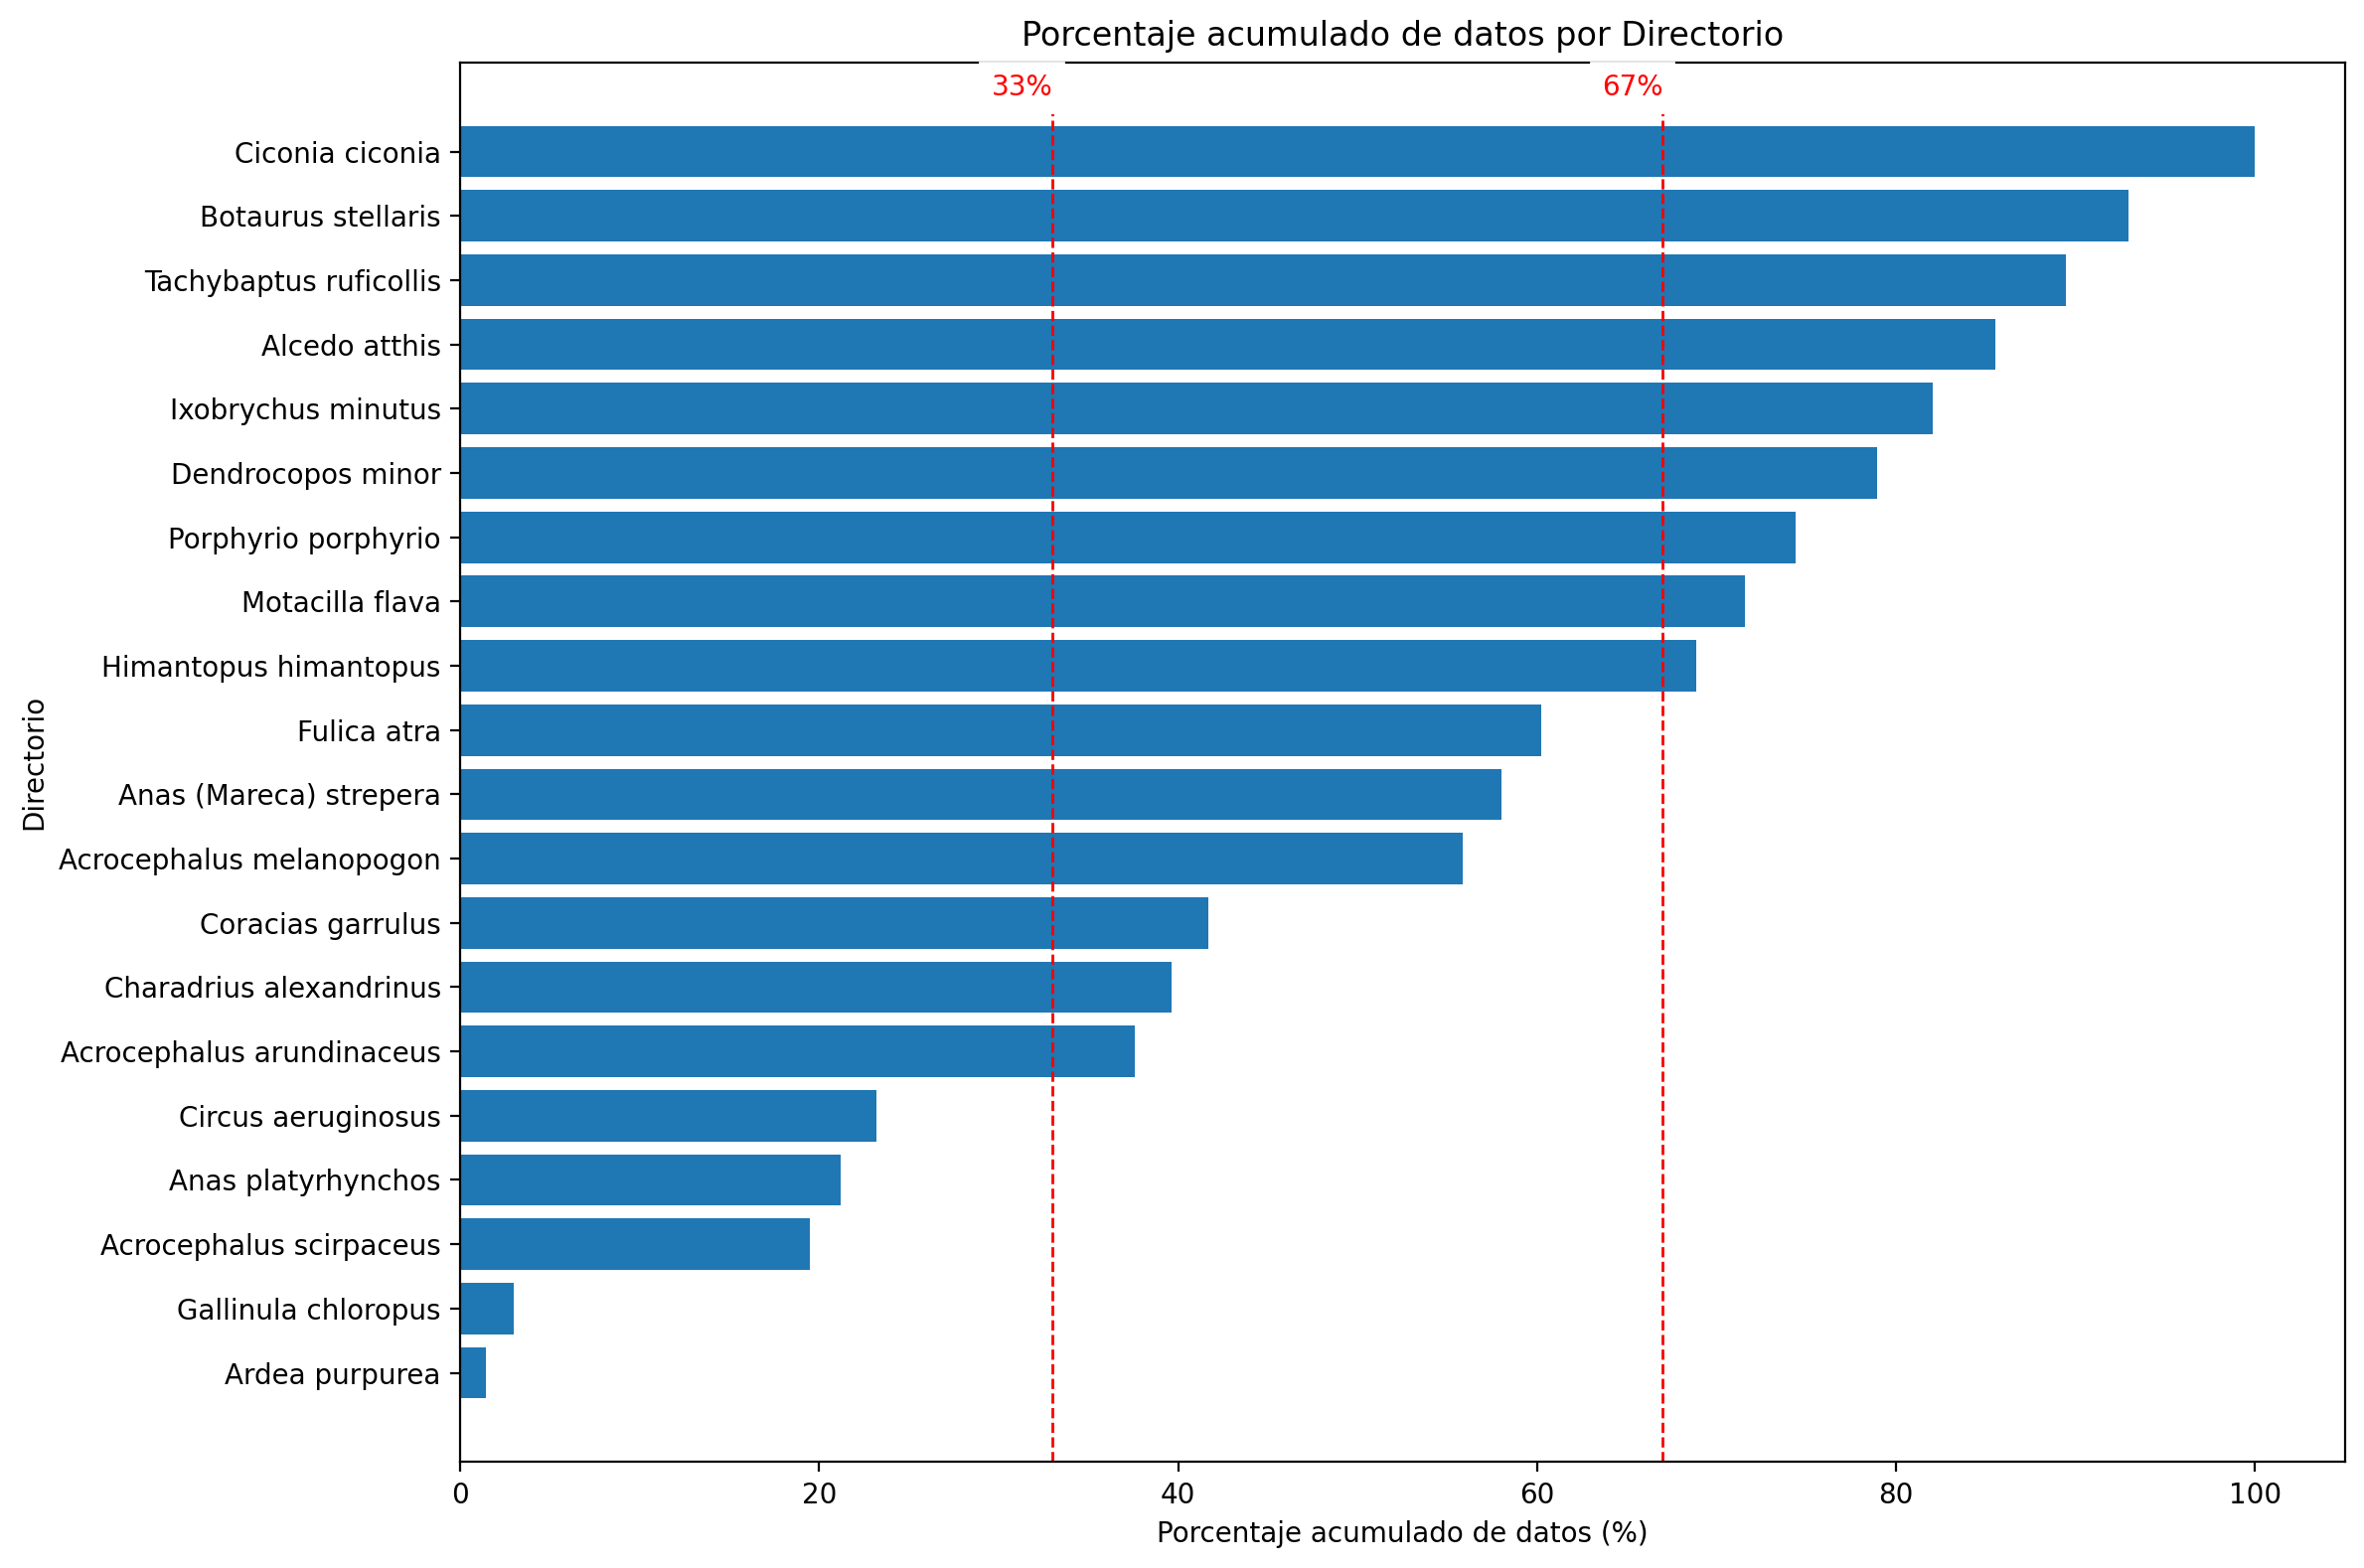

In [ ]:
# Contar la cantidad de datos de cada "Directorio"
count_per_species = df_espectrogramas["Directorio"].value_counts().sort_index()

# Ordenar los directorios de menor a mayor cantidad
sorted_directorios = count_per_species.sort_values()

# Crear listas para alternar entre dos de los más pequeños y uno de los más grandes
alternating_directorios = []
i, j = 0, len(sorted_directorios) - 1

# Alternar dos de menor cantidad primero por cada uno de mayor cantidad
while i <= j:
    if i < len(sorted_directorios):
        alternating_directorios.append(sorted_directorios.index[i])
        i += 1
    if i < len(sorted_directorios):
        alternating_directorios.append(sorted_directorios.index[i])
        i += 1
    if j >= 0:
        alternating_directorios.append(sorted_directorios.index[j])
        j -= 1

# Reorganizar los datos de acuerdo con el nuevo orden
sorted_counts_alternating = sorted_directorios[alternating_directorios]

# Calcular la cantidad acumulada de datos por "Directorio"
cumulative_count = sorted_counts_alternating.cumsum()

# Calcular el porcentaje acumulado de datos
total_count = cumulative_count.iloc[-1]
percentage_cumulative = cumulative_count / total_count * 100

# Crear el diagrama de barras horizontal de porcentaje acumulado de datos por "Directorio"
plt.figure(figsize=(12, 8))
plt.barh(percentage_cumulative.index, percentage_cumulative.values)
plt.ylabel("Directorio")
plt.xlabel("Porcentaje acumulado de datos (%)")
plt.title("Porcentaje acumulado de datos por Directorio")

# Añadir líneas de referencia para 33% y 67%
plt.axvline(33, color='red', linestyle='--', linewidth=1)
plt.axvline(67, color='red', linestyle='--', linewidth=1)

# Añadir etiquetas a las líneas de referencia
plt.text(33, len(percentage_cumulative) - 1, '33%', color='red', va='center', ha='right', backgroundcolor='white')
plt.text(67, len(percentage_cumulative) - 1, '67%', color='red', va='center', ha='right', backgroundcolor='white')

plt.tight_layout()
plt.show()

# 25% datos - 5 Especies

## Separación de los datos (5 especies: "Ardea purpurea","Gallinula chloropus","Acrocephalus scirpaceus","Anas platyrhynchos","Circus aeruginosus")

In [ ]:
# Seleccionamos los datos de los primeras 9 especies
Primeros5directorios = ["Ardea purpurea","Gallinula chloropus","Acrocephalus scirpaceus","Anas platyrhynchos","Circus aeruginosus"]
df = df_espectrogramas[df_espectrogramas['Directorio'].isin(Primeros5directorios)]


# Separamos los datos de los espectrogramas según los datos X e y. El target es adivinar el nombre de la especie, o sea el directorio.
X = df.drop(columns=['Directorio'])
y = df["Directorio"]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Verificar la forma de los datos de X_train y X_test
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (3348, 50176)
X_test shape: (837, 50176)


## Entrenamiento (5 especies: "Ardea purpurea","Gallinula chloropus","Acrocephalus scirpaceus","Anas platyrhynchos","Circus aeruginosus")

In [ ]:
# Diccionario de mapeo
species_dict = {
    "Acrocephalus arundinaceus": 1,
    "Acrocephalus melanopogon": 2,
    "Acrocephalus scirpaceus": 3,
    "Alcedo atthis": 4,
    "Anas (Mareca) strepera": 5,
    "Anas platyrhynchos": 6,
    "Ardea purpurea": 7,
    "Botaurus stellaris": 8,
    "Charadrius alexandrinus": 9,
    "Ciconia ciconia": 10,
    "Circus aeruginosus": 11,
    "Coracias garrulus": 12,
    "Dendrocopos minor": 13,
    "Fulica atra": 14,
    "Gallinula chloropus": 15,
    "Himantopus himantopus": 16,
    "Ixobrychus minutus": 17,
    "Motacilla flava": 18,
    "Porphyrio porphyrio": 19,
    "Tachybaptus ruficollis": 20}

# Cambiamos los nombres en y por números
y_train_num = np.array([species_dict[species] for species in y_train])
y_test_num = np.array([species_dict[species] for species in y_test])

In [ ]:
# Asegurarse de que las imágenes tienen 4 dimensiones
train_images = X_train[..., np.newaxis] / 255.0 if X_train.ndim == 3 else X_train / 255.0
test_images = X_test[..., np.newaxis] / 255.0 if X_test.ndim == 3 else X_test / 255.0

# Verificar la forma de los datos
print(f"train_images shape: {train_images.shape}")
print(f"test_images shape: {test_images.shape}")

train_images shape: (3348, 50176)
test_images shape: (837, 50176)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Escalamos las imágenes entre 0 y 1
train_images = X_train / 255
test_images = X_test / 255

# Definir la arquitectura del modelo con 3 capas ocultas de 5 neuronas
model = models.Sequential([
    layers.Dense(5, activation='relu', input_shape=(train_images.shape[1],)),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(20, activation='softmax')  # Capa de salida con 20 neuronas (20 clases)
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_images, y_train_num, validation_split=0.1, batch_size=256, epochs=10)
# Batch_size son cuantas imágenes pasan en grupo por la red de neuronas + backtrain hasta pasar todas las imágenes que se tienen
# El resultado de dividir Nºtotal imagen/batch_size son cuantas pasadas ha tenido que hacer y es lo que nos  indica en la salida abajo de Epoch que pone NUM/NUM

Epoch 1/10
12/12 [==============================] - 4s 99ms/step - loss: 2.0187 - accuracy: 0.6465 - val_loss: 1.5033 - val_accuracy: 0.7194
Epoch 2/10
12/12 [==============================] - 1s 51ms/step - loss: 1.4668 - accuracy: 0.7063 - val_loss: 1.2300 - val_accuracy: 0.7194
Epoch 3/10
12/12 [==============================] - 1s 48ms/step - loss: 1.2470 - accuracy: 0.7063 - val_loss: 1.0745 - val_accuracy: 0.7194
Epoch 4/10
12/12 [==============================] - 1s 47ms/step - loss: 1.0901 - accuracy: 0.7069 - val_loss: 0.9810 - val_accuracy: 0.7194
Epoch 5/10
12/12 [==============================] - 1s 46ms/step - loss: 1.0112 - accuracy: 0.7066 - val_loss: 0.9233 - val_accuracy: 0.7194
Epoch 6/10
12/12 [==============================] - 1s 47ms/step - loss: 0.9552 - accuracy: 0.7073 - val_loss: 0.8827 - val_accuracy: 0.7194
Epoch 7/10
12/12 [==============================] - 0s 39ms/step - loss: 0.9153 - accuracy: 0.7086 - val_loss: 0.8455 - val_accuracy: 0.7194
Epoch 8/10
12

## Resultados (5 especies: "Ardea purpurea","Gallinula chloropus","Acrocephalus scirpaceus","Anas platyrhynchos","Circus aeruginosus")

<Figure size 1000x800 with 0 Axes>

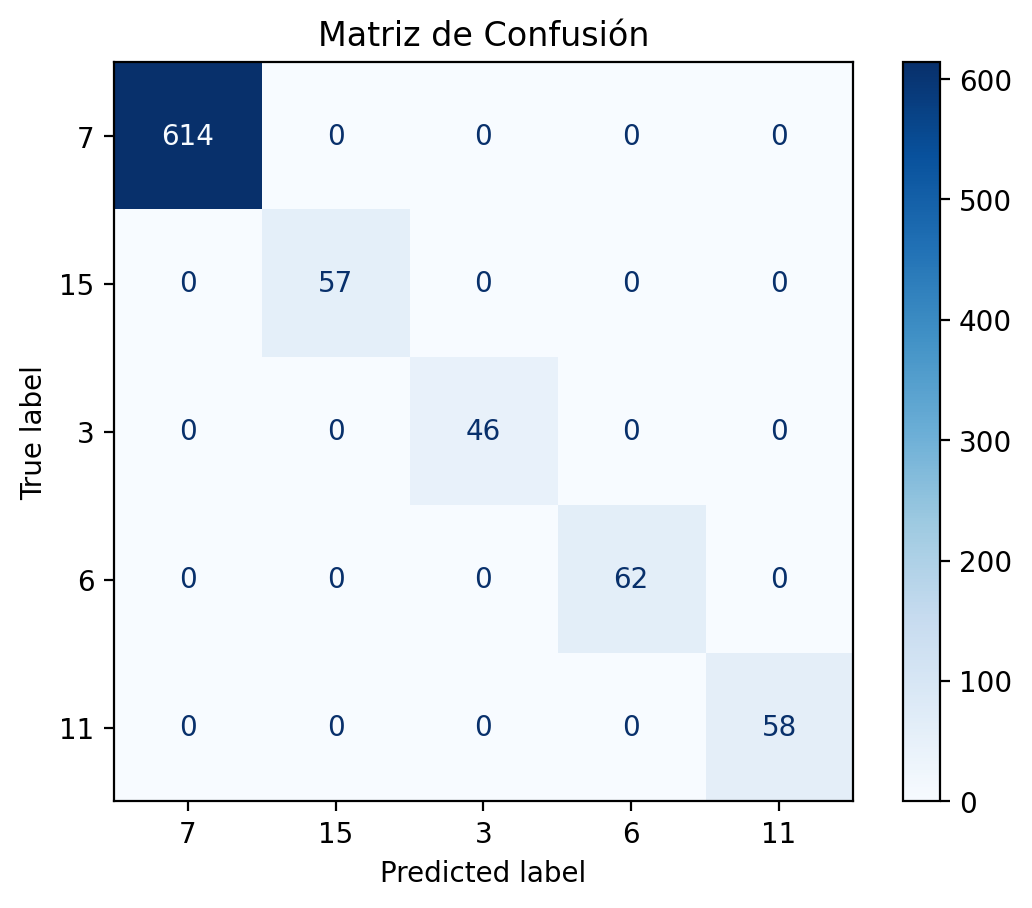

In [ ]:
# Filtrar y convertir a etiquetas numéricas usando species_dict
y_test_num_filtered = np.array([species_dict[species] for species in y_test if species in Primeros5directorios])
test_label_predictions_filtered = np.array([species_dict[species] for species in y_test if species in Primeros5directorios])

# Matriz de confusión para conjunto de prueba
cm = confusion_matrix(y_test_num_filtered, test_label_predictions_filtered)

# Obtener las etiquetas para mostrar en la matriz de confusión
labels = [species_dict[species] for species in Primeros5directorios]

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

105/105 [==============================] - 1s 7ms/step - loss: 0.8109 - accuracy: 0.7646
0.7646356225013733 Accuracy en Train
27/27 [==============================] - 0s 5ms/step - loss: 0.7403 - accuracy: 0.7849
0.7849462628364563 Accuracy en Test


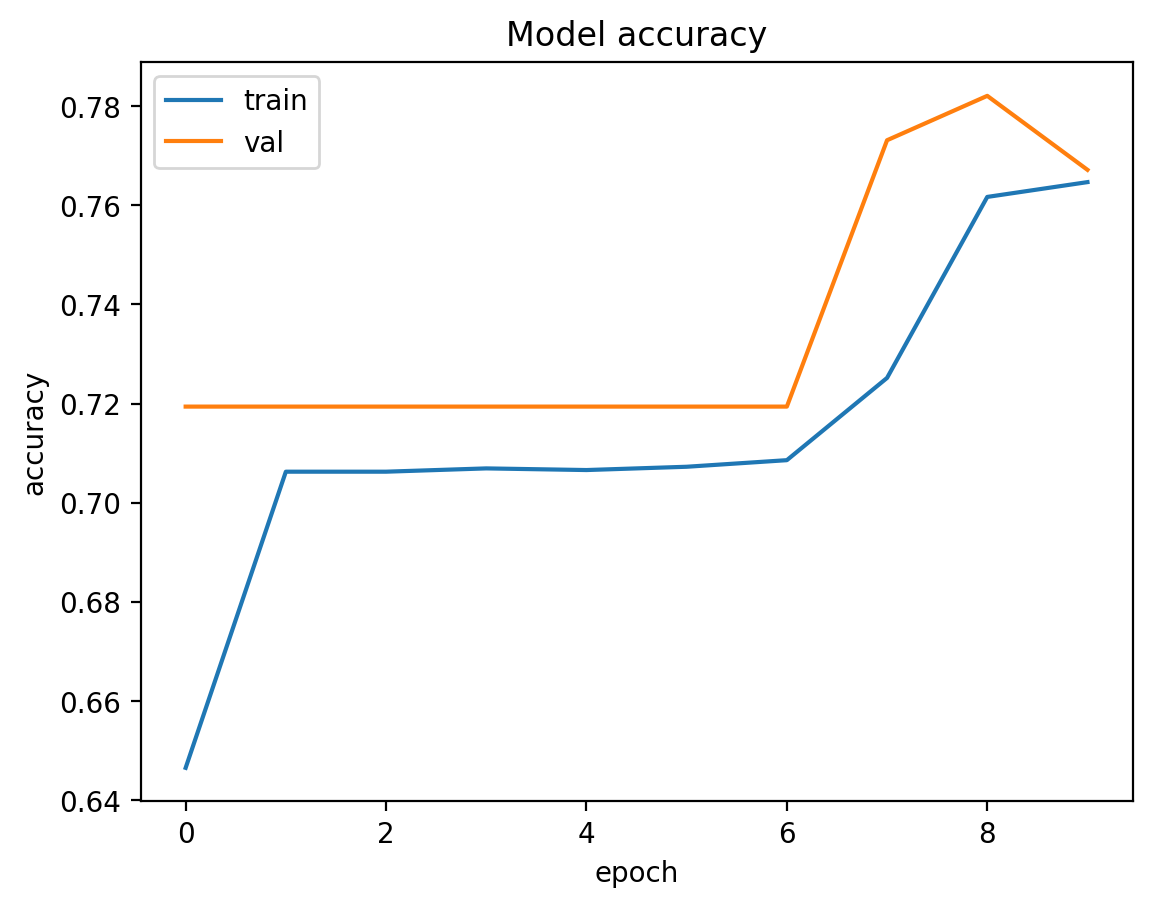

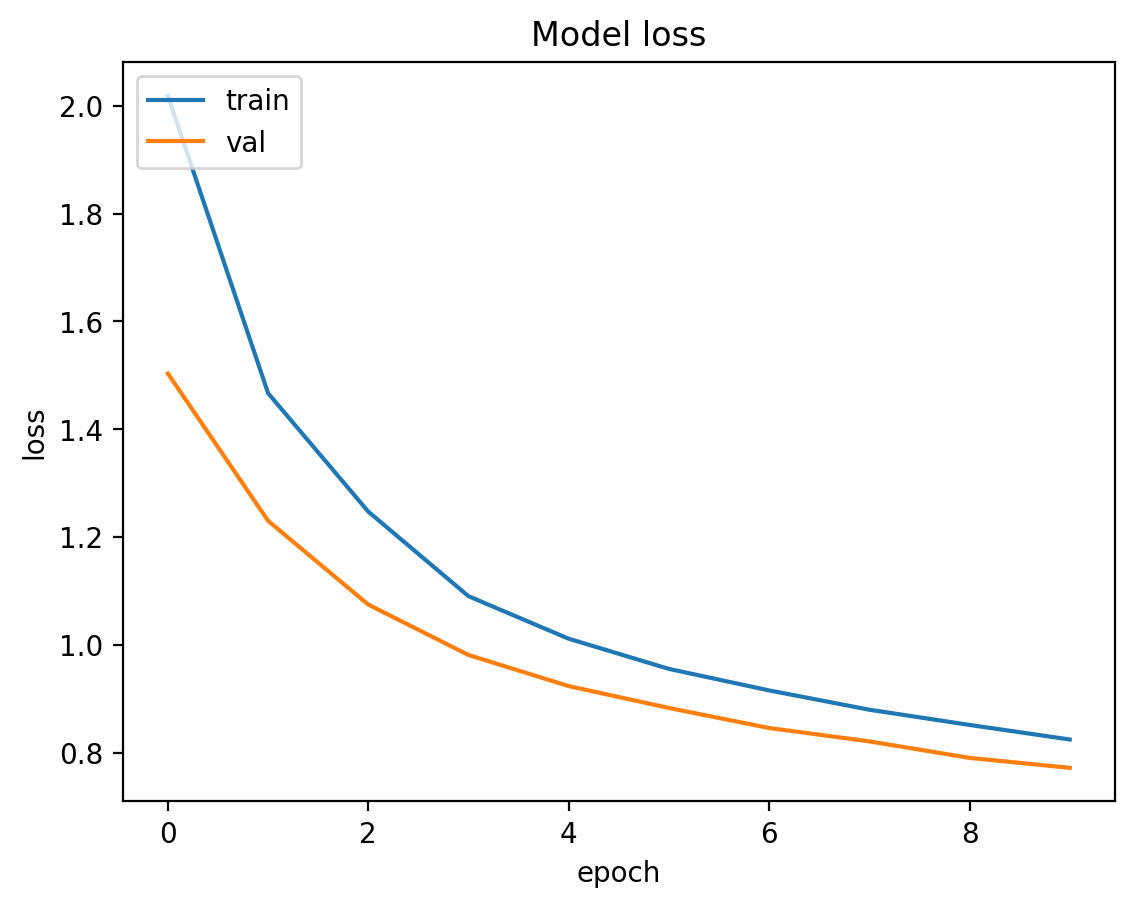

In [ ]:
# Accuracy
accuracy = model.evaluate(train_images, y_train_num)
print(accuracy[1], "Accuracy en Train")
accuracy = model.evaluate(test_images, y_test_num)
print(accuracy[1], "Accuracy en Test")

# Evolución de la accuracy para cada época
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evolución de la loss para cada época
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 25% a 67% datos - 7 Especies

## Separación de los datos (7 especies: "Acrocephalus arundinaceus","Charadrius alexandrinus","Coracias garrulus","Acrocephalus melanopogon","Anas (Mareca) srepera","Fulica atra","Himantopus himantopus")

In [ ]:
# Seleccionamos los datos de los primeras 9 especies
Segundos7directorios = ["Acrocephalus arundinaceus","Charadrius alexandrinus","Coracias garrulus","Acrocephalus melanopogon","Anas (Mareca) srepera","Fulica atra","Himantopus himantopus"]
df = df_espectrogramas[df_espectrogramas['Directorio'].isin(Segundos7directorios)]


# Separamos los datos de los espectrogramas según los datos X e y. El target es adivinar el nombre de la especie, o sea el directorio.
X = df.drop(columns=['Directorio'])
y = df["Directorio"]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Verificar la forma de los datos de X_train y X_test
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (6287, 50176)
X_test shape: (1572, 50176)


## Entrenamiento (7 especies: "Acrocephalus arundinaceus","Charadrius alexandrinus","Coracias garrulus","Acrocephalus melanopogon","Anas (Mareca) srepera","Fulica atra","Himantopus himantopus")

In [ ]:
# Diccionario de mapeo
species_dict = {
    "Acrocephalus arundinaceus": 1,
    "Acrocephalus melanopogon": 2,
    "Acrocephalus scirpaceus": 3,
    "Alcedo atthis": 4,
    "Anas (Mareca) strepera": 5,
    "Anas platyrhynchos": 6,
    "Ardea purpurea": 7,
    "Botaurus stellaris": 8,
    "Charadrius alexandrinus": 9,
    "Ciconia ciconia": 10,
    "Circus aeruginosus": 11,
    "Coracias garrulus": 12,
    "Dendrocopos minor": 13,
    "Fulica atra": 14,
    "Gallinula chloropus": 15,
    "Himantopus himantopus": 16,
    "Ixobrychus minutus": 17,
    "Motacilla flava": 18,
    "Porphyrio porphyrio": 19,
    "Tachybaptus ruficollis": 20}

# Cambiamos los nombres en y por números
y_train_num = np.array([species_dict[species] for species in y_train])
y_test_num = np.array([species_dict[species] for species in y_test])

In [ ]:
# Asegurarse de que las imágenes tienen 4 dimensiones
train_images = X_train[..., np.newaxis] / 255.0 if X_train.ndim == 3 else X_train / 255.0
test_images = X_test[..., np.newaxis] / 255.0 if X_test.ndim == 3 else X_test / 255.0

# Verificar la forma de los datos
print(f"train_images shape: {train_images.shape}")
print(f"test_images shape: {test_images.shape}")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Escalamos las imágenes entre 0 y 1
train_images = X_train / 255
test_images = X_test / 255

# Definir la arquitectura del modelo con 3 capas ocultas de 5 neuronas
model = models.Sequential([
    layers.Dense(5, activation='relu', input_shape=(train_images.shape[1],)),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(20, activation='softmax')  # Capa de salida con 20 neuronas (20 clases)
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_images, y_train_num, validation_split=0.1, batch_size=256, epochs=10)
# Batch_size son cuantas imágenes pasan en grupo por la red de neuronas + backtrain hasta pasar todas las imágenes que se tienen
# El resultado de dividir Nºtotal imagen/batch_size son cuantas pasadas ha tenido que hacer y es lo que nos  indica en la salida abajo de Epoch que pone NUM/NUM

## Resultados (7 especies: "Acrocephalus arundinaceus","Charadrius alexandrinus","Coracias garrulus","Acrocephalus melanopogon","Anas (Mareca) srepera","Fulica atra","Himantopus himantopus")

In [ ]:
# Filtrar y convertir a etiquetas numéricas usando species_dict
y_test_num_filtered = np.array([species_dict[species] for species in y_test if species in Primeros5directorios])
test_label_predictions_filtered = np.array([species_dict[species] for species in y_test if species in Primeros5directorios])

# Matriz de confusión para conjunto de prueba
cm = confusion_matrix(y_test_num_filtered, test_label_predictions_filtered)

# Obtener las etiquetas para mostrar en la matriz de confusión
labels = [species_dict[species] for species in Primeros5directorios]

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Accuracy
accuracy = model.evaluate(train_images, y_train_num)
print(accuracy[1], "Accuracy en Train")
accuracy = model.evaluate(test_images, y_test_num)
print(accuracy[1], "Accuracy en Test")

# Evolución de la accuracy para cada época
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evolución de la loss para cada época
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Eliminar datos (max n datos / directorio)

Se intentó con n = 1000, 800, 600, 500, 400 y 300 datos y se seguía llenando la RAM

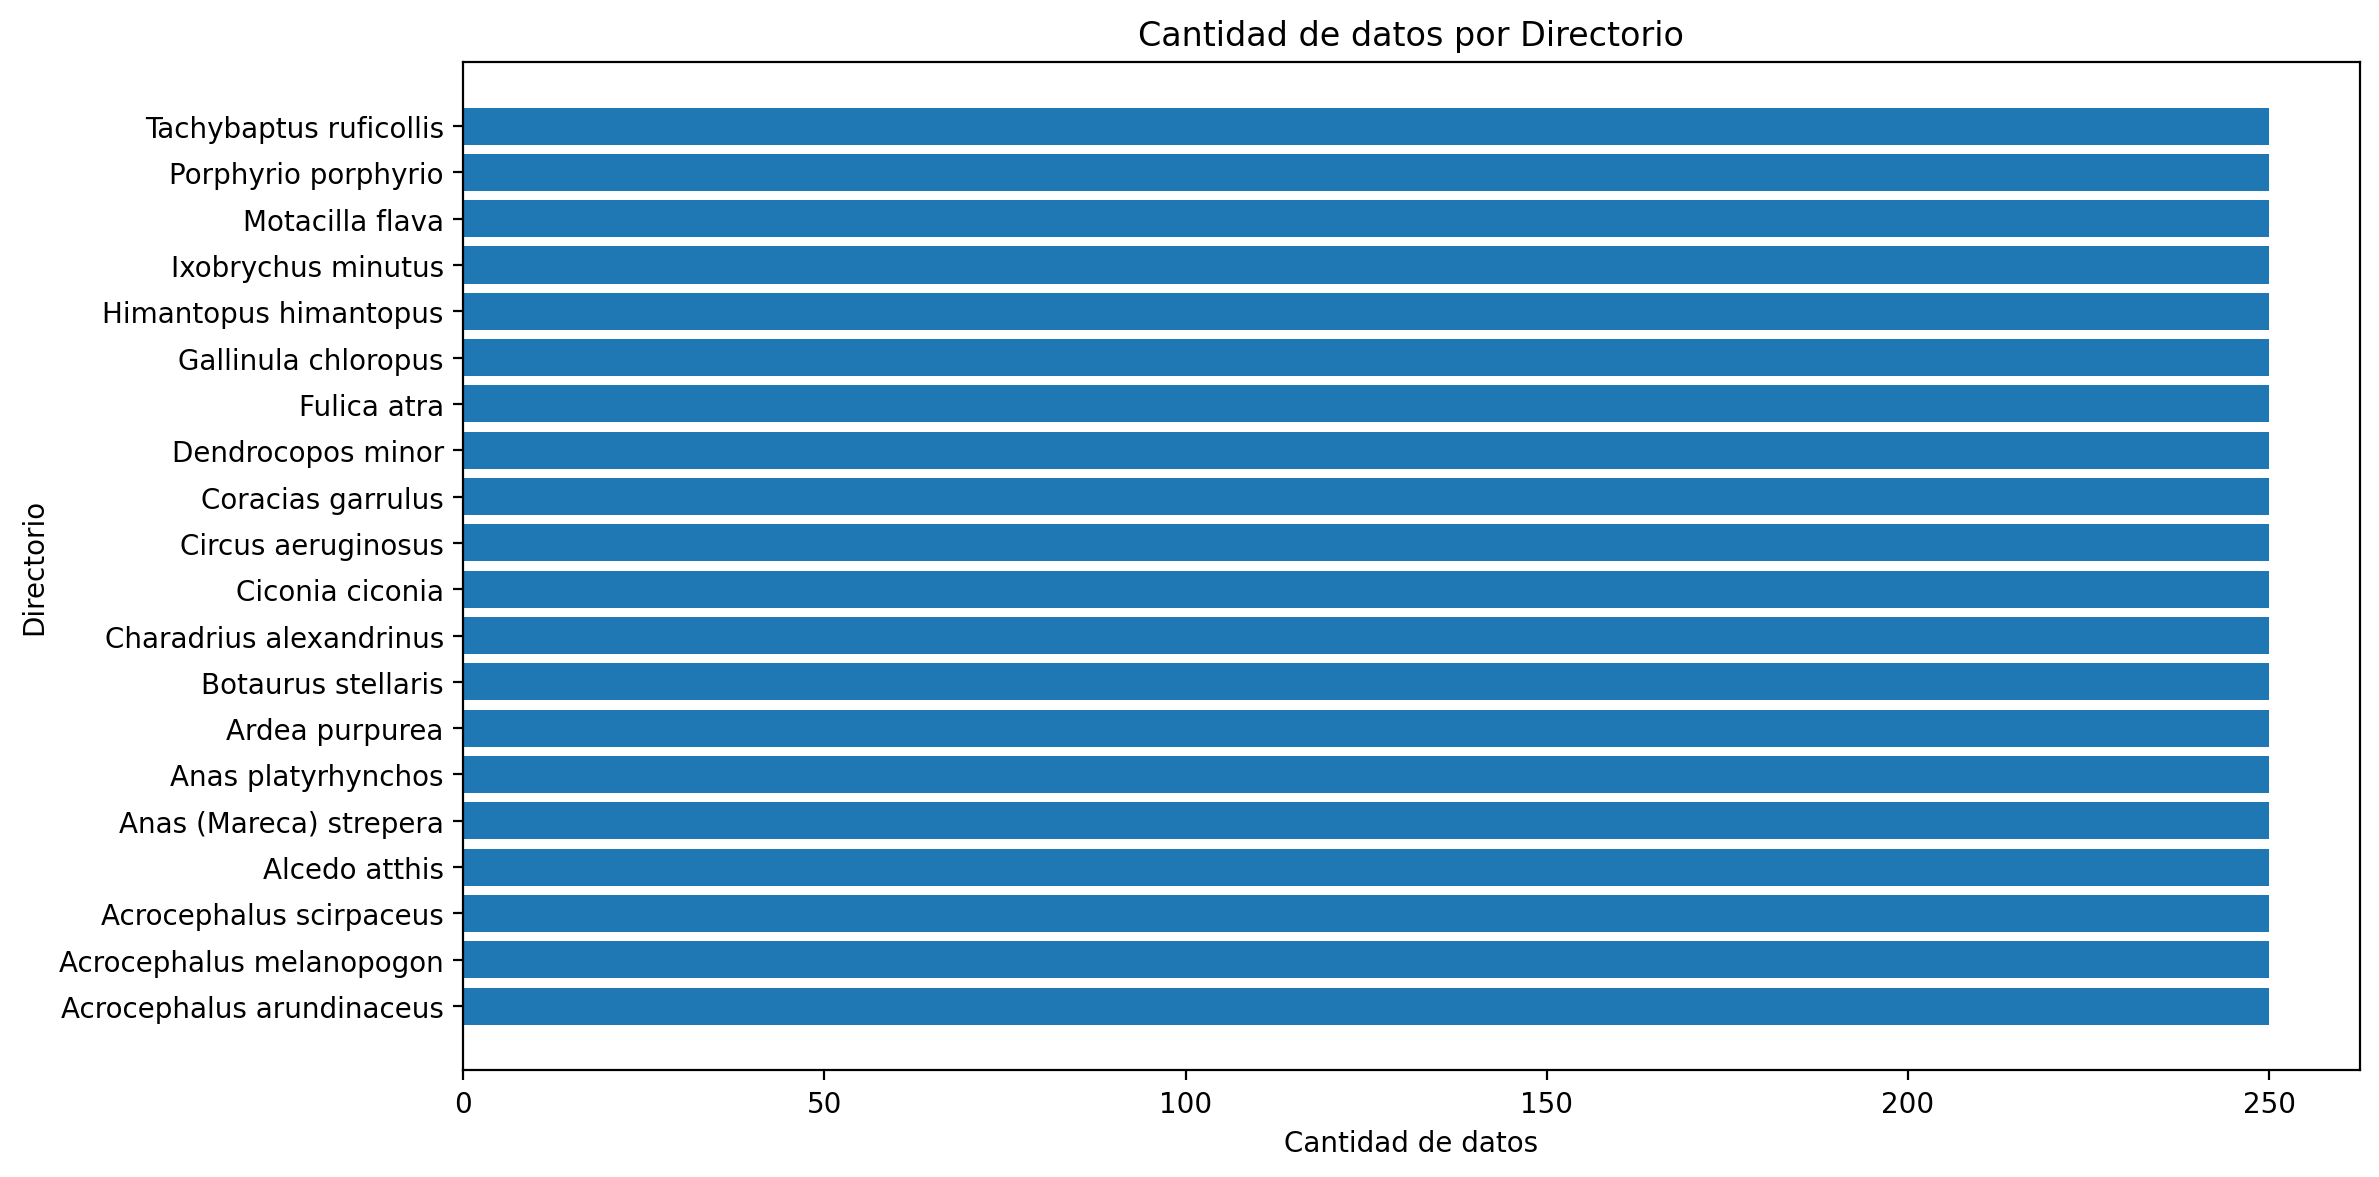

,Espectrograma_0,Espectrograma_1,Espectrograma_2,Espectrograma_3,Espectrograma_4,Espectrograma_5,Espectrograma_6,Espectrograma_7,Espectrograma_8,Espectrograma_9,...,Espectrograma_50167,Espectrograma_50168,Espectrograma_50169,Espectrograma_50170,Espectrograma_50171,Espectrograma_50172,Espectrograma_50173,Espectrograma_50174,Espectrograma_50175,Directorio
4998,-9.738127,-10.524836,-10.942780,-14.682041,-12.004075,-11.104856,-11.736212,-14.077700,-11.244049,-8.943102,...,-50.788853,-51.550224,-68.128922,-53.114231,-53.762081,-59.508427,-80.000000,-61.600624,-62.844707,Ixobrychus minutus
4999,-6.338783,-6.401998,-9.134276,-13.083508,-10.309858,-9.595956,-10.346846,-9.663582,-7.493694,-8.623126,...,-22.525990,-24.834969,-37.678391,-63.920097,-57.698967,-61.856720,-62.071503,-55.862381,-51.545158,Ixobrychus minutus


In [3]:
n = 250 # Parámetro número de datos máximo por directorio
# Calcular la cantidad de datos por Directorio
count_per_species = df_espectrogramas['Directorio'].value_counts()

# Identificar los directorios que tienen más y menos de n datos
directorios_con_mas_de_n = count_per_species[count_per_species > n].index
directorios_con_menos_de_n = count_per_species[count_per_species < n].index

# Crear una máscara booleana para seleccionar aleatoriamente n filas de esos directorios
random_samples = []
for dir in directorios_con_mas_de_n:
    indices = df_espectrogramas[df_espectrogramas['Directorio'] == dir].index # Listado de índices de datos con ese nombre de dir
    random_samples.extend(np.random.choice(indices, size=min(n, len(indices)), replace=False)) # Números al azar

# Crear df con los espectogramas de mas de n cortados y concatenar los menores de n
df = df_espectrogramas[df_espectrogramas.index.isin(random_samples)]
df = pd.concat([df, df_espectrogramas[df_espectrogramas['Directorio'].isin(directorios_con_menos_de_n)]], ignore_index=True)

# Graficar cantidad de datos de cada "Directorio"
count_per_species = df["Directorio"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.barh(count_per_species.index, count_per_species.values)
plt.ylabel("Directorio")
plt.xlabel("Cantidad de datos")
plt.title("Cantidad de datos por Directorio")
plt.tight_layout()
plt.show()

df.tail(2)

## Separación de los datos (max n datos / directorio)

In [4]:
# Separamos los datos de los espectrogramas según los datos X e y. El target es adivinar el nombre de la especie, o sea el directorio.
X = df.drop(columns=['Directorio'])
y = df["Directorio"]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Verificar la forma de los datos de X_train y X_test
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (4000, 50176)
X_test shape: (1000, 50176)


## Entrenamiento (max n datos / directorio)

In [5]:
# Diccionario de mapeo
species_dict = {
    "Acrocephalus arundinaceus": 1,
    "Acrocephalus melanopogon": 2,
    "Acrocephalus scirpaceus": 3,
    "Alcedo atthis": 4,
    "Anas (Mareca) strepera": 5,
    "Anas platyrhynchos": 6,
    "Ardea purpurea": 7,
    "Botaurus stellaris": 8,
    "Charadrius alexandrinus": 9,
    "Ciconia ciconia": 10,
    "Circus aeruginosus": 11,
    "Coracias garrulus": 12,
    "Dendrocopos minor": 13,
    "Fulica atra": 14,
    "Gallinula chloropus": 15,
    "Himantopus himantopus": 16,
    "Ixobrychus minutus": 17,
    "Motacilla flava": 18,
    "Porphyrio porphyrio": 19,
    "Tachybaptus ruficollis": 20}

# Cambiamos los nombres en y por números
y_train_num = np.array([species_dict[species] for species in y_train])
y_test_num = np.array([species_dict[species] for species in y_test])

In [ ]:
# Asegurarse de que las imágenes tienen 4 dimensiones
train_images = X_train[..., np.newaxis] / 255.0 if X_train.ndim == 3 else X_train / 255.0
test_images = X_test[..., np.newaxis] / 255.0 if X_test.ndim == 3 else X_test / 255.0

# Verificar la forma de los datos
print(f"train_images shape: {train_images.shape}")
print(f"test_images shape: {test_images.shape}")

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Escalamos las imágenes entre 0 y 1
train_images = X_train / 255
test_images = X_test / 255

# Definir la arquitectura del modelo con 3 capas ocultas de 5 neuronas
model = models.Sequential([
    layers.Dense(5, activation='relu', input_shape=(train_images.shape[1],)),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(20, activation='softmax')  # Capa de salida con 20 neuronas (20 clases)
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_images, y_train_num, validation_split=0.1, batch_size=256, epochs=10)
# Batch_size son cuantas imágenes pasan en grupo por la red de neuronas + backtrain hasta pasar todas las imágenes que se tienen
# El resultado de dividir Nºtotal imagen/batch_size son cuantas pasadas ha tenido que hacer y es lo que nos  indica en la salida abajo de Epoch que pone NUM/NUM

Epoch 1/10
15/15 [==============================] - 4s 86ms/step - loss: nan - accuracy: 0.0042 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 1s 49ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 1s 43ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 1s 43ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/10
15/15 [==============================] - 1s 54ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/10
15/15 [==============================] - 1s 44ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/10
15/15 [==============================] - 1s 42ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epo

## Resultados (max n datos / directorio)

<Figure size 1000x800 with 0 Axes>

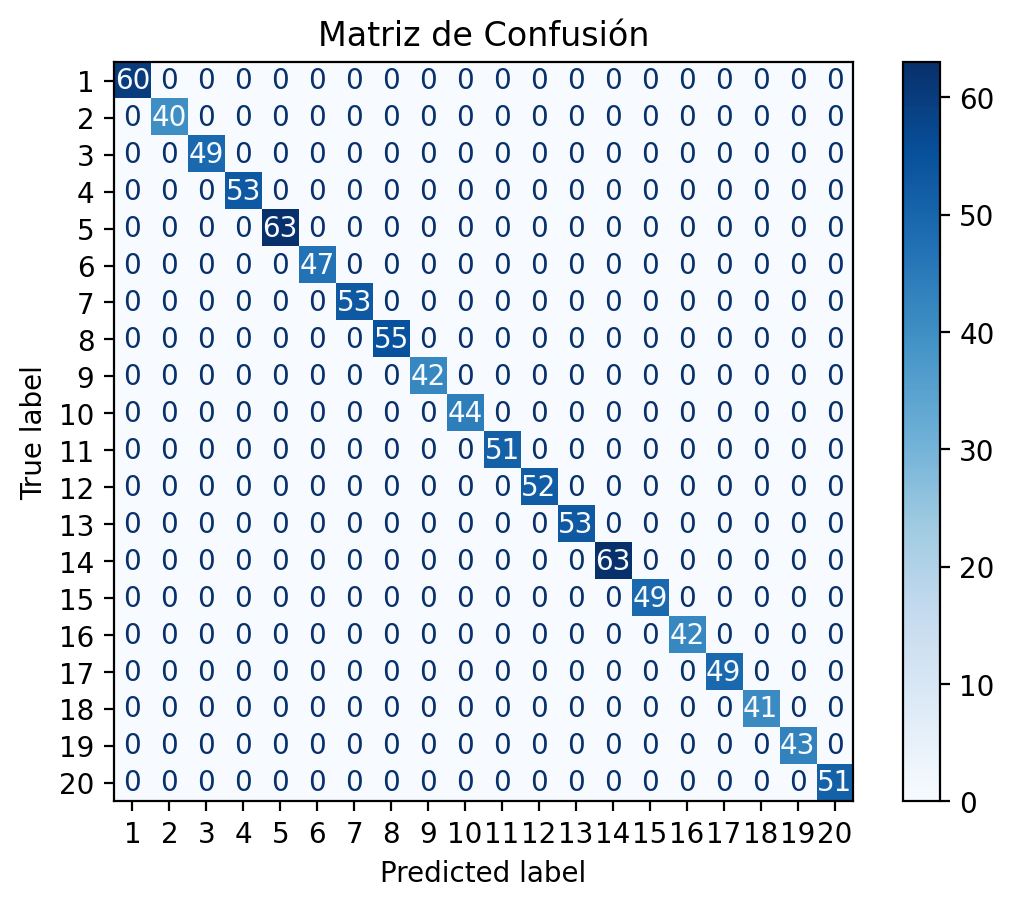

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Filtrar y convertir a etiquetas numéricas usando species_dict
all_species = [
    "Acrocephalus arundinaceus",
    "Acrocephalus melanopogon",
    "Acrocephalus scirpaceus",
    "Alcedo atthis",
    "Anas (Mareca) strepera",
    "Anas platyrhynchos",
    "Ardea purpurea",
    "Botaurus stellaris",
    "Charadrius alexandrinus",
    "Ciconia ciconia",
    "Circus aeruginosus",
    "Coracias garrulus",
    "Dendrocopos minor",
    "Fulica atra",
    "Gallinula chloropus",
    "Himantopus himantopus",
    "Ixobrychus minutus",
    "Motacilla flava",
    "Porphyrio porphyrio",
    "Tachybaptus ruficollis"]
y_test_num_filtered = np.array([species_dict[species] for species in y_test if species in all_species])
test_label_predictions_filtered = np.array([species_dict[species] for species in y_test if species in all_species])

# Matriz de confusión para conjunto de prueba
cm = confusion_matrix(y_test_num, test_label_predictions_filtered)

# Obtener las etiquetas para mostrar en la matriz de confusión
labels = [species_dict[species] for species in all_species]

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

125/125 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.0000e+00
0.0 Accuracy en Train
32/32 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0000e+00
0.0 Accuracy en Test


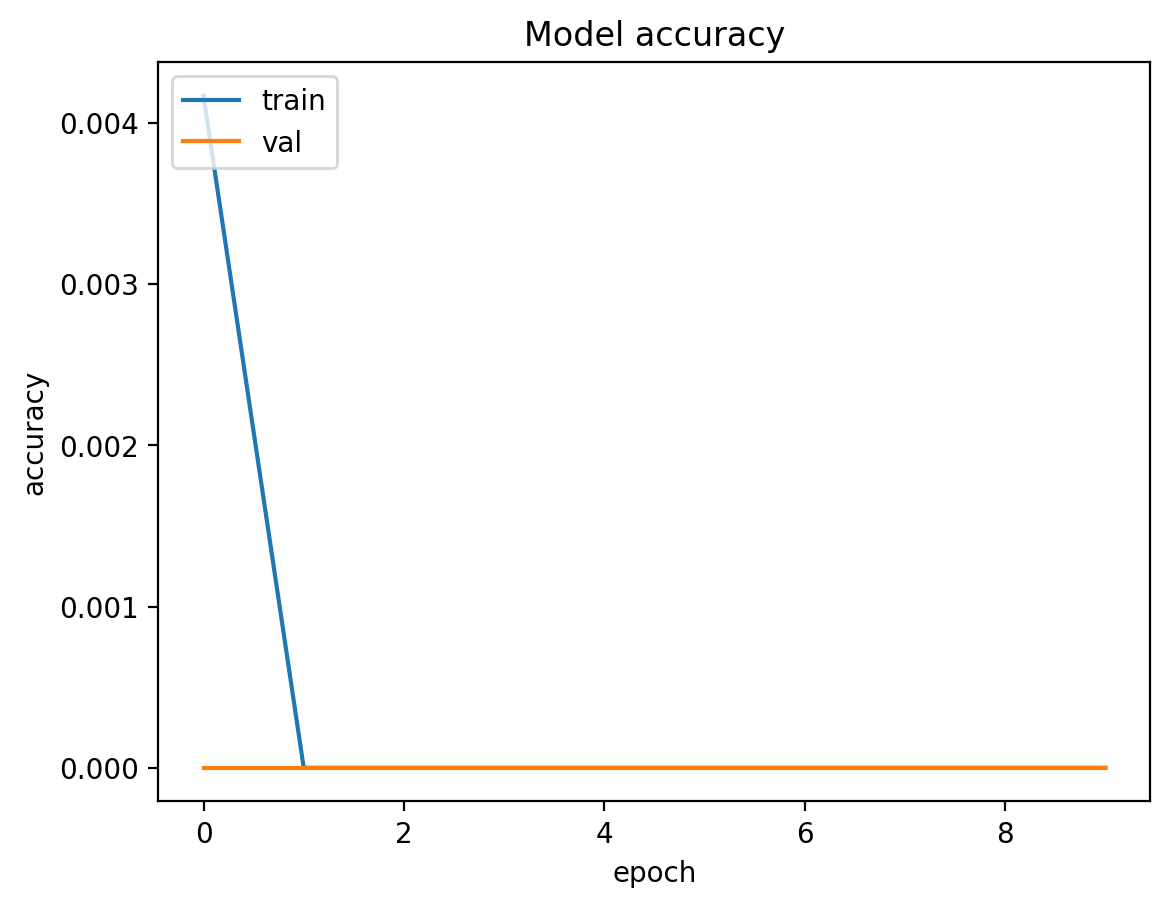

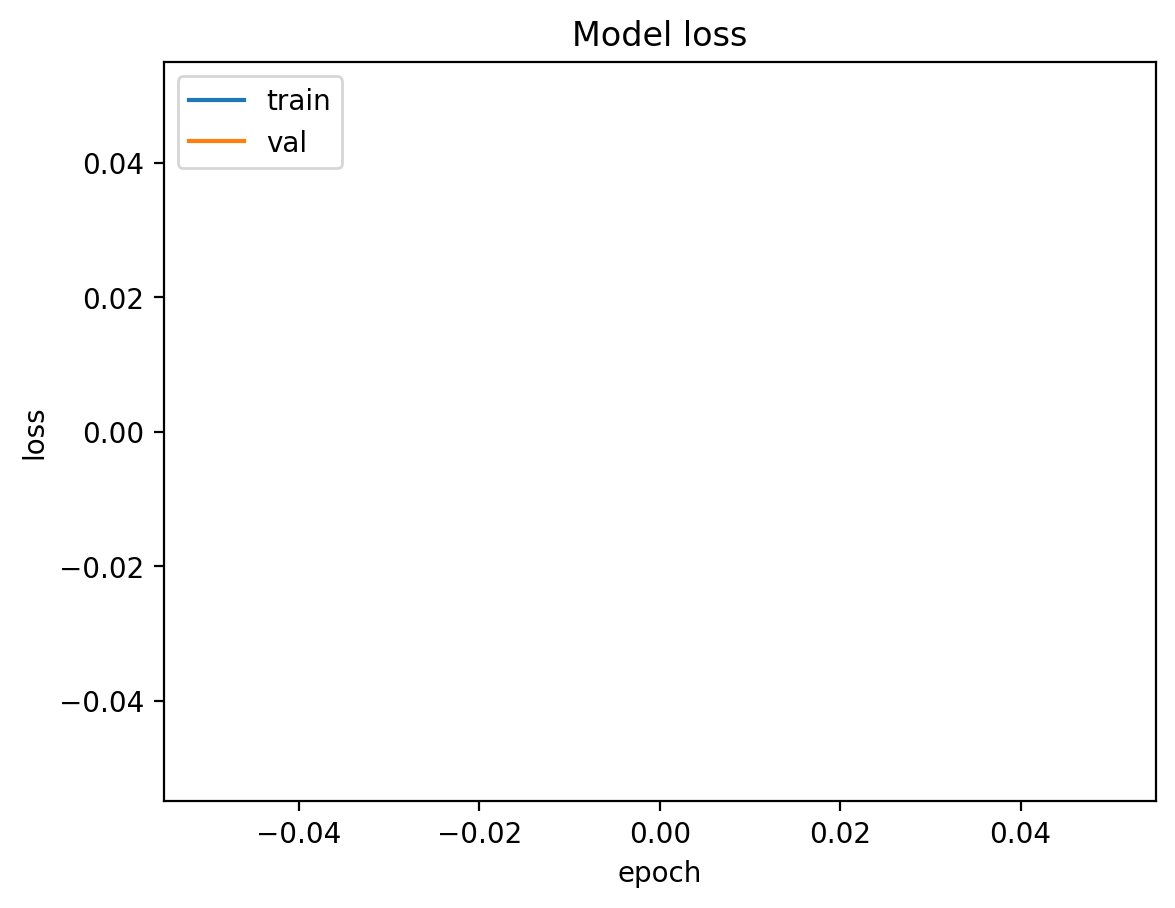

In [8]:
# Accuracy
accuracy = model.evaluate(train_images, y_train_num)
print(accuracy[1], "Accuracy en Train")
accuracy = model.evaluate(test_images, y_test_num)
print(accuracy[1], "Accuracy en Test")

# Evolución de la accuracy para cada época
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evolución de la loss para cada época
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Eliminar información

In [3]:
p = 70 # Porcentaje de información a eliminar

# Selección columnas que tienen el prefijo "Espectrograma"
espectograma_columns = [col for col in df_espectrogramas.columns if col.startswith("Espectrograma")]

# Determinar cuántas columnas corresponden al p%
num_to_remove = int(len(espectograma_columns) * p/100)

# Seleccionar aleatoriamente las columnas que se eliminarán, equiespaiadas
indices = np.linspace(0, len(espectograma_columns) - 1, num_to_remove, dtype=int)
columns_to_remove = [espectograma_columns[i] for i in indices]

# Eliminar las columnas seleccionadas del DataFrame
df_espectrogramas_reduced = df_espectrogramas.drop(columns=columns_to_remove)

# Verificar la eliminación
print("Número de columnas originales:", len(df_espectrogramas.columns))
print("Número de columnas después de eliminar el 70%:", len(df_espectrogramas_reduced.columns))

Número de columnas originales: 50177
Número de columnas después de eliminar el 70%: 15054


# Separación de los datos (eliminar información)

In [4]:
df = df_espectrogramas_reduced
# Separamos los datos de los espectrogramas según los datos X e y. El target es adivinar el nombre de la especie, o sea el directorio.
X = df.drop(columns=['Directorio'])
y = df["Directorio"]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Verificar la forma de los datos de X_train y X_test
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (13924, 15053)
X_test shape: (3482, 15053)


## Entrenamiento (eliminar información)

In [5]:
# Diccionario de mapeo
species_dict = {
    "Acrocephalus arundinaceus": 1,
    "Acrocephalus melanopogon": 2,
    "Acrocephalus scirpaceus": 3,
    "Alcedo atthis": 4,
    "Anas (Mareca) strepera": 5,
    "Anas platyrhynchos": 6,
    "Ardea purpurea": 7,
    "Botaurus stellaris": 8,
    "Charadrius alexandrinus": 9,
    "Ciconia ciconia": 10,
    "Circus aeruginosus": 11,
    "Coracias garrulus": 12,
    "Dendrocopos minor": 13,
    "Fulica atra": 14,
    "Gallinula chloropus": 15,
    "Himantopus himantopus": 16,
    "Ixobrychus minutus": 17,
    "Motacilla flava": 18,
    "Porphyrio porphyrio": 19,
    "Tachybaptus ruficollis": 20}

# Cambiamos los nombres en y por números
y_train_num = np.array([species_dict[species] for species in y_train])
y_test_num = np.array([species_dict[species] for species in y_test])

In [ ]:
# Asegurarse de que las imágenes tienen 4 dimensiones
train_images = X_train[..., np.newaxis] / 255.0 if X_train.ndim == 3 else X_train / 255.0
test_images = X_test[..., np.newaxis] / 255.0 if X_test.ndim == 3 else X_test / 255.0

# Verificar la forma de los datos
print(f"train_images shape: {train_images.shape}")
print(f"test_images shape: {test_images.shape}")

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Escalamos las imágenes entre 0 y 1
train_images = X_train / 255
test_images = X_test / 255

# Definir la arquitectura del modelo con 3 capas ocultas de 5 neuronas
model = models.Sequential([
    layers.Dense(5, activation='relu', input_shape=(train_images.shape[1],)),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(20, activation='softmax')  # Capa de salida con 20 neuronas (20 clases)
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_images, y_train_num-1, validation_split=0.1, batch_size=256, epochs=10)
# Batch_size son cuantas imágenes pasan en grupo por la red de neuronas + backtrain hasta pasar todas las imágenes que se tienen
# El resultado de dividir Nºtotal imagen/batch_size son cuantas pasadas ha tenido que hacer y es lo que nos  indica en la salida abajo de Epoch que pone NUM/NUM

Epoch 1/10
49/49 [==============================] - 4s 49ms/step - loss: 2.9164 - accuracy: 0.1348 - val_loss: 2.8700 - val_accuracy: 0.1443
Epoch 2/10
49/49 [==============================] - 1s 22ms/step - loss: 2.8144 - accuracy: 0.1515 - val_loss: 2.7966 - val_accuracy: 0.1486
Epoch 3/10
49/49 [==============================] - 1s 22ms/step - loss: 2.7419 - accuracy: 0.1527 - val_loss: 2.7546 - val_accuracy: 0.1450
Epoch 4/10
49/49 [==============================] - 1s 22ms/step - loss: 2.6821 - accuracy: 0.1551 - val_loss: 2.6789 - val_accuracy: 0.1457
Epoch 5/10
49/49 [==============================] - 1s 22ms/step - loss: 2.6282 - accuracy: 0.1586 - val_loss: 2.6182 - val_accuracy: 0.1500
Epoch 6/10
49/49 [==============================] - 1s 21ms/step - loss: 2.5497 - accuracy: 0.1819 - val_loss: 2.5300 - val_accuracy: 0.1981
Epoch 7/10
49/49 [==============================] - 1s 23ms/step - loss: 2.4297 - accuracy: 0.2077 - val_loss: 2.4108 - val_accuracy: 0.2103
Epoch 8/10
49

## Resultados (eliminar información)

<Figure size 3000x2400 with 0 Axes>

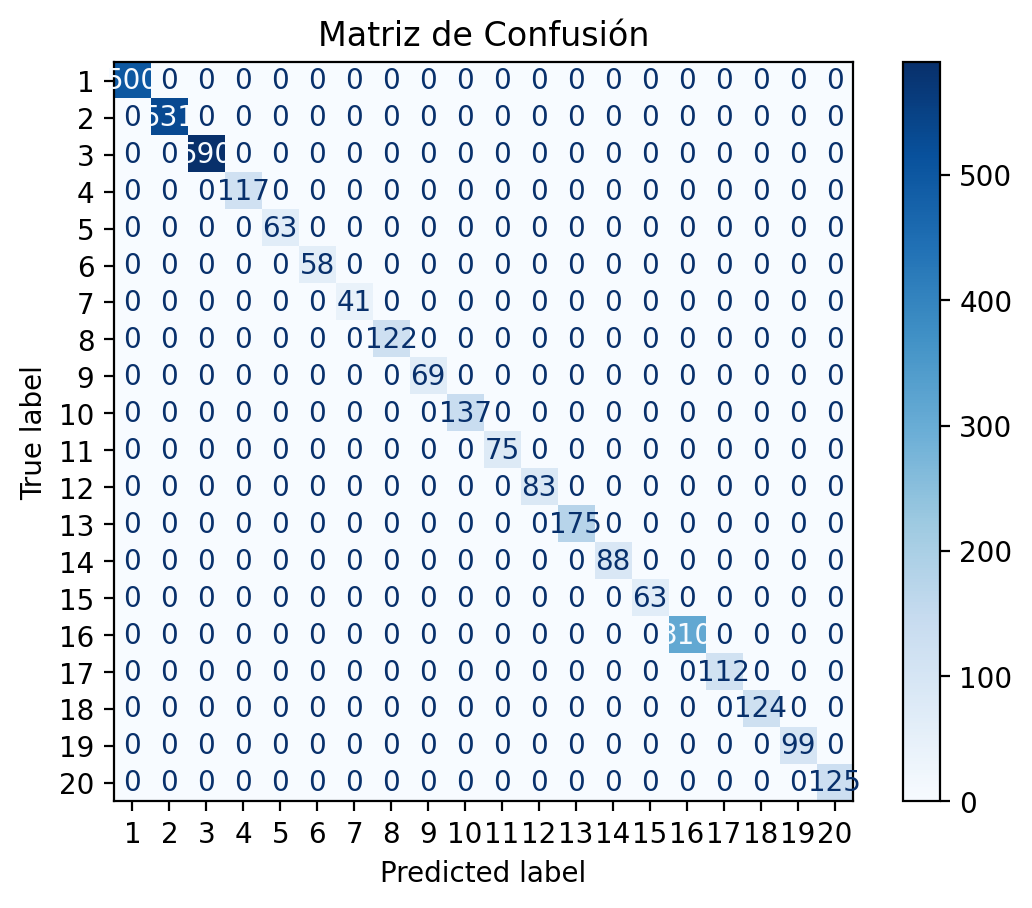

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Filtrar y convertir a etiquetas numéricas usando species_dict
all_species = [
    "Acrocephalus arundinaceus",
    "Acrocephalus melanopogon",
    "Acrocephalus scirpaceus",
    "Alcedo atthis",
    "Anas (Mareca) strepera",
    "Anas platyrhynchos",
    "Ardea purpurea",
    "Botaurus stellaris",
    "Charadrius alexandrinus",
    "Ciconia ciconia",
    "Circus aeruginosus",
    "Coracias garrulus",
    "Dendrocopos minor",
    "Fulica atra",
    "Gallinula chloropus",
    "Himantopus himantopus",
    "Ixobrychus minutus",
    "Motacilla flava",
    "Porphyrio porphyrio",
    "Tachybaptus ruficollis"]
y_test_num_filtered = np.array([species_dict[species] for species in y_test if species in all_species])
test_label_predictions_filtered = np.array([species_dict[species] for species in y_test if species in all_species])

# Matriz de confusión para conjunto de prueba
cm = confusion_matrix(y_test_num, test_label_predictions_filtered)

# Obtener las etiquetas para mostrar en la matriz de confusión
labels = [species_dict[species] for species in all_species]

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(30, 24))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

436/436 [==============================] - 1s 3ms/step - loss: 2.1136 - accuracy: 0.2535
0.25351911783218384 Accuracy en Train
109/109 [==============================] - 0s 3ms/step - loss: 2.1186 - accuracy: 0.2395
0.23951752483844757 Accuracy en Test


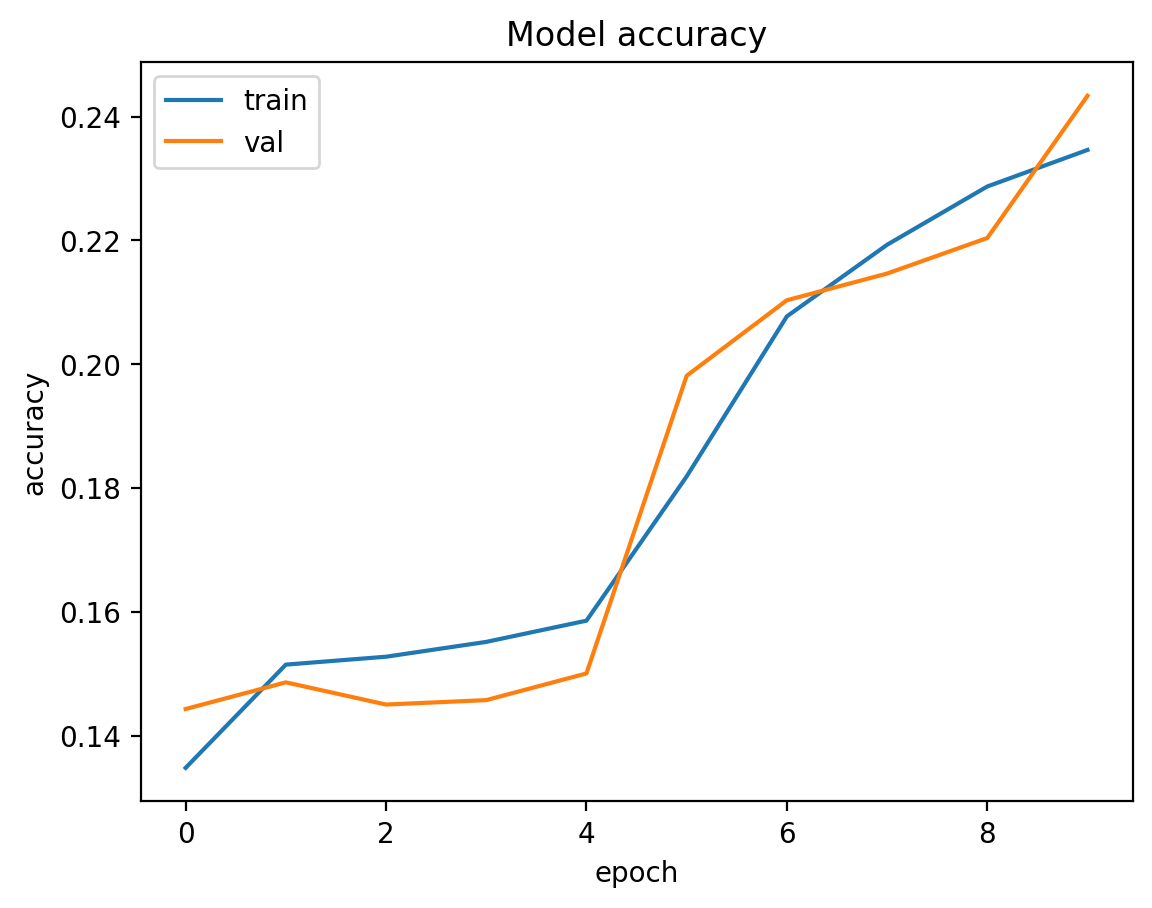

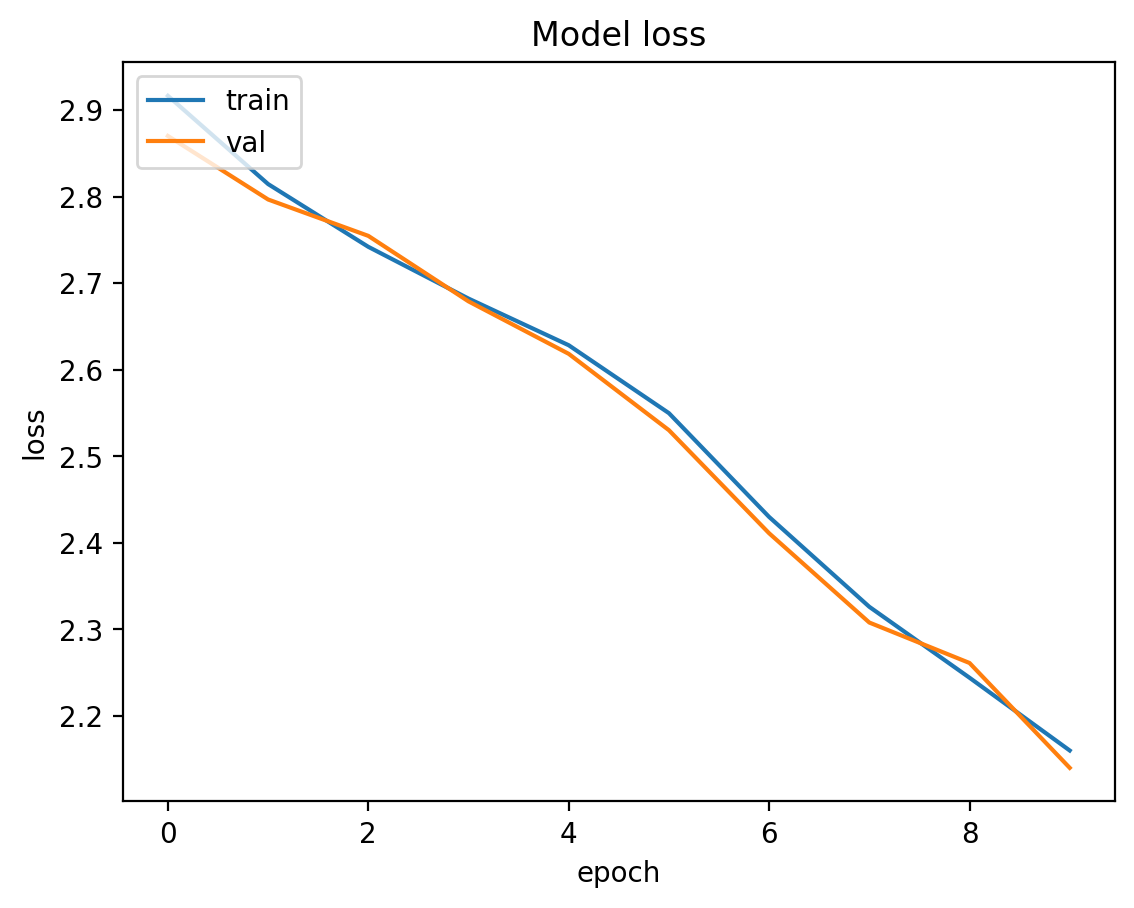

In [11]:
# Accuracy
accuracy = model.evaluate(train_images, y_train_num-1)
print(accuracy[1], "Accuracy en Train")
accuracy = model.evaluate(test_images, y_test_num-1)
print(accuracy[1], "Accuracy en Test")

# Evolución de la accuracy para cada época
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evolución de la loss para cada época
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()